PART 3 & PART 4

In [1]:
# =============================================================================
# INSTALL PACKAGES
# =============================================================================
# Use a single pip command for efficiency in Colab.
# Versions have been updated for compatibility with recent Colab environments.
# Removed version constraints for 'accelerate' and 'peft' to allow pip to find compatible versions.
!pip install pandas==2.2.2 numpy==1.26.4 torch==2.3.1 scikit-learn==1.5.0 matplotlib==3.9.0 seaborn==0.13.2 datasets==2.19.1 transformers==4.41.2 setfit==1.0.3 optuna huggingface-hub==0.23.0 peft accelerate

"""
Patent Classification: Sequential Step-by-Step Implementation
============================================================

This notebook implements Parts 3 and 4 step by step, with immediate execution and output.
Each section builds on the previous one sequentially.
"""

# =============================================================================
# SETUP AND DATA PREPARATION
# =============================================================================

import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from datasets import Dataset, Features, Value, ClassLabel
from setfit import SetFitModel, Trainer, TrainingArguments
import time
import warnings
warnings.filterwarnings('ignore')


# %%
# Set reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
INFO: pip is looking at multiple versions of peft to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/542.0 kB ? eta -:--:--
   ---------------------------------------- 542.0/542.0 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.1 MB 3.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/9.1 MB 3.4 MB/s eta 0:00:03
   --------- ------------------------------ 2.1/9.1 MB 3.3 MB/s eta 0:00:03
   ------------ --------------------------- 2.9/9.1 MB 3.5 MB/s eta 0:00:02
   ----------------- ---------------------- 3.9/9.1 MB 3.9 MB/s eta 0:00:02
   --------------------- ------------------ 5.0/9.1 MB 4.1 MB/s eta 0:00:02
   ------------------------- -------------- 5.8/9

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# The path you copied from the file explorer
file_path = '/content/drive/MyDrive/patent_corpus.csv'

# Use the path to read your data
df = pd.read_csv(file_path)

# Now you can work with your dataframe
print(df.head())

# Store the original number of rows
original_rows = df.shape[0]
print(f"Original DataFrame shape: ({original_rows}, {df.shape[1]})")

  publication_number                                           abstract label
0       US-6036316-A  A visual axis detecting device includes an ima...     a
1       US-5992338-A  An seed metering device and method for disburs...     a
2      US-9295833-B2  An implantable lead for sensing mechanical act...     a
3       US-5765296-A  An exercise shoe is capable of adapting its fi...     a
4      US-6509013-B1  Phosphate-binding polymers are provided for re...     a
Original DataFrame shape: (67068, 3)


In [5]:
# Deduplicate and reassign the result back to the 'df' variable
df = df.drop_duplicates(subset=['abstract'])

# Store the new number of rows
deduplicated_rows = df.shape[0]
print(f"Shape after deduplication: ({deduplicated_rows}, {df.shape[1]})")

# Calculate and print the number of duplicates removed
num_duplicates_removed = original_rows - deduplicated_rows
print(f"\nNumber of duplicate rows removed: {num_duplicates_removed}")

# Display the head of the final DataFrame
print("\nHead of the final DataFrame:")
print(df.head())

Shape after deduplication: (65739, 3)

Number of duplicate rows removed: 1329

Head of the final DataFrame:
  publication_number                                           abstract label
0       US-6036316-A  A visual axis detecting device includes an ima...     a
1       US-5992338-A  An seed metering device and method for disburs...     a
2      US-9295833-B2  An implantable lead for sensing mechanical act...     a
3       US-5765296-A  An exercise shoe is capable of adapting its fi...     a
4      US-6509013-B1  Phosphate-binding polymers are provided for re...     a


In [6]:
# Map labels to numeric if needed
if df['label'].dtype == 'object':
    label_mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'y': 8}
    df['label'] = df['label'].str.lower().map(label_mapping)

df = df.dropna().reset_index(drop=True)

# Address severe class imbalance by rebalancing
print("Original label distribution:")
print(df['label'].value_counts().sort_index())

Original label distribution:
label
0     9457
1     8861
2     5511
3      561
4     1883
5     4695
6    14103
7    13920
8     6748
Name: count, dtype: int64


In [7]:
from sklearn.utils import resample
import pandas as pd

# Store original column names and order
original_columns = df.columns.tolist()

print("Original dataset distribution:")
print(df['label'].value_counts().sort_index())

# First, create train/validation/test splits with ORIGINAL imbalanced data
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_df_original, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=SEED)

print(f"\nOriginal splits (before balancing train):")
print(f"Train: {len(train_df_original)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

print(f"\nOriginal train set distribution (imbalanced):")
print(train_df_original['label'].value_counts().sort_index())

# Set target samples per class for TRAINING SET ONLY
target_samples = 5000  # Adjust based on your needs

# Resample ONLY the training set
resampled_train_dfs = []

for label in sorted(train_df_original['label'].unique()):
    class_df = train_df_original[train_df_original['label'] == label]
    current_count = len(class_df)

    if current_count < target_samples:
        # Oversample minority classes (with replacement)
        resampled_class = resample(class_df,
                                 replace=True,
                                 n_samples=target_samples,
                                 random_state=42)
    else:
        # Undersample majority classes (without replacement)
        resampled_class = resample(class_df,
                                 replace=False,
                                 n_samples=target_samples,
                                 random_state=42)

    resampled_train_dfs.append(resampled_class)

# Combine and shuffle ONLY the training set
train_df = pd.concat(resampled_train_dfs, ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df[original_columns]  # Maintain original column order

# Validation and test sets remain unchanged (natural imbalanced distribution)

print(f"\nFinal data splits:")
print(f"Train: {len(train_df)} samples (BALANCED)")
print(f"Validation: {len(val_df)} samples (NATURAL DISTRIBUTION)")
print(f"Test: {len(test_df)} samples (NATURAL DISTRIBUTION)")

print(f"\nBalanced TRAIN set distribution:")
print(train_df['label'].value_counts().sort_index())

print(f"\nNatural VALIDATION set distribution:")
print(val_df['label'].value_counts().sort_index())

print(f"\nNatural TEST set distribution:")
print(test_df['label'].value_counts().sort_index())


Original dataset distribution:
label
0     9457
1     8861
2     5511
3      561
4     1883
5     4695
6    14103
7    13920
8     6748
Name: count, dtype: int64

Original splits (before balancing train):
Train: 39443 samples
Validation: 13148 samples
Test: 13148 samples

Original train set distribution (imbalanced):
label
0    5674
1    5317
2    3307
3     337
4    1130
5    2817
6    8461
7    8352
8    4048
Name: count, dtype: int64

Final data splits:
Train: 45000 samples (BALANCED)
Validation: 13148 samples (NATURAL DISTRIBUTION)
Test: 13148 samples (NATURAL DISTRIBUTION)

Balanced TRAIN set distribution:
label
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
Name: count, dtype: int64

Natural VALIDATION set distribution:
label
0    1892
1    1772
2    1102
3     112
4     376
5     939
6    2821
7    2784
8    1350
Name: count, dtype: int64

Natural TEST set distribution:
label
0    1891
1    1772
2    1102
3     112
4     377
5     939
6

In [8]:

# Analyze the distributions
train_imbalance = train_df['label'].value_counts().max() / train_df['label'].value_counts().min()
val_imbalance = val_df['label'].value_counts().max() / val_df['label'].value_counts().min()
test_imbalance = test_df['label'].value_counts().max() / test_df['label'].value_counts().min()

print(f"\nImbalance ratios:")
print(f"Train set: {train_imbalance:.2f}:1 (should be close to 1.0)")
print(f"Validation set: {val_imbalance:.2f}:1 (natural distribution)")
print(f"Test set: {test_imbalance:.2f}:1 (natural distribution)")


Imbalance ratios:
Train set: 1.00:1 (should be close to 1.0)
Validation set: 25.19:1 (natural distribution)
Test set: 25.19:1 (natural distribution)


In [9]:
import os

import os

# @markdown <br>Enter your W&B API Key below and press Enter.
# @markdown You can find your API key by visiting: https://wandb.ai/authorize
WANDB_API_KEY = 'ae8b975f1b67498589a5d7e85e4562ee780079f7' # @param {type:"string"}

if WANDB_API_KEY:
    os.environ['WANDB_API_KEY'] = WANDB_API_KEY
    print("WANDB_API_KEY set as environment variable.")
else:
    print("WANDB_API_KEY not provided. You may be prompted to login.")

# Optionally, you can also set other W&B environment variables here
# os.environ['WANDB_PROJECT'] = 'my-project-name'
# os.environ['WANDB_ENTITY'] = 'my-entity-name'
# os.environ['WANDB_NOTEBOOK_NAME'] = 'My Colab Notebook'
import os

# @markdown <br>Enter your W&B API Key below and press Enter.
# @markdown You can find your API key by visiting: https://wandb.ai/authorize
WANDB_API_KEY = 'ae8b975f1b67498589a5d7e85e4562ee780079f7' # @param {type:"string"}

if WANDB_API_KEY:
    os.environ['WANDB_API_KEY'] = WANDB_API_KEY
    print("WANDB_API_KEY set as environment variable.")
else:
    print("WANDB_API_KEY not provided. You may be prompted to login.")


WANDB_API_KEY set as environment variable.
WANDB_API_KEY set as environment variable.


In [10]:
# =============================================================================
# HYPERPARAMETER TUNING WITH OPTUNA
# =============================================================================
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import time
import torch
from sklearn.metrics import accuracy_score, f1_score
from setfit import SetFitModel
import gc
import pandas as pd
from sklearn.model_selection import train_test_split

print("Starting hyperparameter optimization with Optuna...")

# Configuration for hyperparameter tuning
TUNING_CONFIG = {
    'n_trials': 3,  # Number of hyperparameter combinations to try
    'timeout': 3600,  # Maximum time in seconds (1 hour)
    'n_jobs': 1,  # Number of parallel jobs (keep 1 for GPU stability)
    'seed': SEED,
    'metric': 'macro_f1',  # Optimization metric: 'accuracy', 'macro_f1', 'micro_f1'
    'use_best_data_percentage': True,  # Use best percentage from learning curve
    'data_percentage': 0.25,  # Fixed percentage if not using best from learning curve
    'val_samples': 10000,  # Validation samples for tuning (smaller for speed)
}

def create_tuning_datasets():
    """Create datasets for hyperparameter tuning"""
    print("Preparing datasets for hyperparameter tuning...")

    # Use best performing data percentage from learning curve if available
    # Check if learning_curve_results exists and is not None
    learning_curve_exists = 'learning_curve_results' in globals() and learning_curve_results is not None
    if TUNING_CONFIG['use_best_data_percentage'] and learning_curve_exists:
        successful_results = {pct: res for pct, res in learning_curve_results.items()
                            if 'error' not in res}
        if successful_results:
            # Ensure key exists before accessing value
            best_pct = max(successful_results.keys(),
                          key=lambda pct: successful_results.get(pct, {}).get('macro_f1', -1)) # Use .get safely
            tuning_percentage = best_pct
            print(f"Using best data percentage from learning curve: {tuning_percentage*100:.0f}%")
        else:
            tuning_percentage = TUNING_CONFIG['data_percentage']
            print(f"No successful learning curve results, using default: {tuning_percentage*100:.0f}%")
    else:
        tuning_percentage = TUNING_CONFIG['data_percentage']
        print(f"Using fixed data percentage: {tuning_percentage*100:.0f}%")

    # Create training subset
    if tuning_percentage >= 1.0:
        tune_train_df = train_df.copy()
    else:
        # Ensure tune_train_df is defined even if train_size is 0 or splitting fails
        tune_train_df = pd.DataFrame(columns=train_df.columns) # Initialize empty
        if len(train_df) > 0 and tuning_percentage > 0:
             tune_train_df, _ = train_test_split(
                train_df, train_size=tuning_percentage,
                stratify=train_df['label'], random_state=SEED
            )

    # Create validation subset for tuning
    # Ensure tune_val_df is defined even if sampling fails
    tune_val_df = pd.DataFrame(columns=val_df.columns) # Initialize empty
    if len(val_df) > 0 and TUNING_CONFIG['val_samples'] > 0:
        tune_val_df = val_df.sample(n=min(TUNING_CONFIG['val_samples'], len(val_df)),
                                random_state=SEED)

    print(f"Tuning train samples: {len(tune_train_df)}")
    print(f"Tuning validation samples: {len(tune_val_df)}")

    # Check class distribution
    train_classes = sorted(tune_train_df['label'].unique()) if not tune_train_df.empty else []
    val_classes = sorted(tune_val_df['label'].unique()) if not tune_val_df.empty else []
    expected_classes = list(range(9))

    train_missing = set(expected_classes) - set(train_classes)
    val_missing = set(expected_classes) - set(val_classes)

    print(f"Training classes: {train_classes}")
    print(f"Validation classes: {val_classes}")
    print(f"Training has all classes: {len(train_missing) == 0}")
    print(f"Validation has all classes: {len(val_missing) == 0}")

    if train_missing:
        print(f"WARNING: Missing classes in training: {sorted(train_missing)}")
    if val_missing:
        print(f"WARNING: Missing classes in validation: {sorted(val_missing)}")

    return tune_train_df, tune_val_df

def objective(trial):
    """Objective function for Optuna optimization"""

    # Suggest hyperparameters (only valid SetFit parameters)
    hyperparams = {
        'num_epochs': trial.suggest_int('num_epochs', 1, 5),
        'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
        'max_length': trial.suggest_categorical('max_length', [128, 256, 512]),
    }

    # Initialize model as None so it can be checked in the except block
    model = None

    try:
        # Create model with suggested hyperparameters
        # Use the globally defined unique_labels
        model = SetFitModel.from_pretrained(
            "AI-Growth-Lab/PatentSBERTa",
            labels=unique_labels # Use the defined unique_labels
        )
        model.to(DEVICE)

        # Prepare training data
        train_texts = tune_train_df['abstract'].tolist()
        train_labels = [int(label) for label in tune_train_df['label']]

        # Prepare validation data
        val_texts = tune_val_df['abstract'].tolist()
        val_labels = [int(label) for label in tune_val_df['label']]

        # Train model with hyperparameters (using only valid SetFit parameters)
        start_time = time.time()

        model.fit(
            x_train=train_texts,
            y_train=train_labels,
            num_epochs=hyperparams['num_epochs'],
            batch_size=hyperparams['batch_size'],
            max_length=hyperparams['max_length']
        )

        training_time = time.time() - start_time

        # Evaluate model
        predictions = model.predict(val_texts)

        # Calculate metrics
        accuracy = accuracy_score(val_labels, predictions)
        macro_f1 = f1_score(val_labels, predictions, average='macro', zero_division=0)
        micro_f1 = f1_score(val_labels, predictions, average='micro', zero_division=0)

        # Select metric to optimize
        if TUNING_CONFIG['metric'] == 'accuracy':
            objective_value = accuracy
        elif TUNING_CONFIG['metric'] == 'macro_f1':
            objective_value = macro_f1
        elif TUNING_CONFIG['metric'] == 'micro_f1':
            objective_value = micro_f1
        else:
            objective_value = macro_f1  # Default

        # Report for pruning
        trial.report(objective_value, step=hyperparams['num_epochs'])

        # Clean up
        del model
        torch.cuda.empty_cache()
        gc.collect()

        return objective_value

    except Exception as e:
        # Clean up on error
        if model is not None: # Only delete if model was successfully created
            del model
        torch.cuda.empty_cache()
        gc.collect()

        # Return poor score for failed trials
        return 0.0

def run_hyperparameter_tuning():
    """Run hyperparameter optimization"""

    print("="*80)
    print("HYPERPARAMETER OPTIMIZATION")
    print("="*80)

    # Prepare datasets
    global tune_train_df, tune_val_df
    tune_train_df, tune_val_df = create_tuning_datasets()

    # Create study with reduced logging
    sampler = TPESampler(seed=TUNING_CONFIG['seed'])
    pruner = MedianPruner(
        n_startup_trials=5,  # Number of trials before pruning starts
        n_warmup_steps=1,    # Number of steps before pruning
        interval_steps=1     # Pruning interval
    )

    # Set Optuna logging to WARNING to reduce verbosity
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=pruner,
        study_name='setfit_hyperparameter_optimization'
    )

    print(f"\nStarting optimization:")
    print(f"  Trials: {TUNING_CONFIG['n_trials']}")
    print(f"  Timeout: {TUNING_CONFIG['timeout']}s")
    print(f"  Metric: {TUNING_CONFIG['metric']}")

    # Run optimization
    start_time = time.time()

    study.optimize(
        objective,
        n_trials=TUNING_CONFIG['n_trials'],
        timeout=TUNING_CONFIG['timeout'],
        n_jobs=TUNING_CONFIG['n_jobs'],
        catch=(Exception,),
        show_progress_bar=False  # Disable progress bar for cleaner output
    )

    optimization_time = time.time() - start_time

    # Print only final results
    print(f"\n{'='*80}")
    print("OPTIMIZATION RESULTS")
    print(f"{'='*80}")

    print(f"Total optimization time: {optimization_time:.1f}s")
    print(f"Number of completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")

    if study.best_trial is not None:
        print(f"\nBest {TUNING_CONFIG['metric']}: {study.best_value:.3f}")

        print(f"\nBest hyperparameters:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")

        return study.best_params, study.best_value, study
    else:
        print("\nNo successful trials completed!")
        return None, None, study

def train_final_model_with_best_params(best_params, validation_split=0.2):
    """Train final model with best hyperparameters on full dataset"""

    if best_params is None:
        print("No best parameters available. Skipping final model training.")
        return None

    print(f"\n{'='*80}")
    print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
    print(f"{'='*80}")

    print("Best hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    # Initialize final_model as None so it can be checked in the except block
    final_model = None

    try:
        # Use full training dataset
        final_train_texts = train_df['abstract'].tolist()
        final_train_labels = [int(label) for label in train_df['label']]

        # Use full validation dataset
        final_val_texts = val_df['abstract'].tolist()
        final_val_labels = [int(label) for label in val_df['label']]

        print(f"\nTraining on {len(final_train_texts)} samples")
        print(f"Validating on {len(final_val_texts)} samples")

        # Create and train final model
        # Use the globally defined unique_labels
        final_model = SetFitModel.from_pretrained(
            "AI-Growth-Lab/PatentSBERTa",
            labels=unique_labels # Use the defined unique_labels
        )
        final_model.to(DEVICE)

        start_time = time.time()

        # Train final model with best hyperparameters (using only valid SetFit parameters)
        final_model.fit(
            x_train=final_train_texts,
            y_train=final_train_labels,
            num_epochs=best_params['num_epochs'],
            batch_size=best_params['batch_size'],
            max_length=best_params['max_length']
        )

        training_time = time.time() - start_time

        # Evaluate final model
        final_predictions = final_model.predict(final_val_texts)

        final_accuracy = accuracy_score(final_val_labels, final_predictions)
        final_macro_f1 = f1_score(final_val_labels, final_predictions, average='macro', zero_division=0)
        final_micro_f1 = f1_score(final_val_labels, final_predictions, average='micro', zero_division=0)

        print(f"\nFinal model performance:")
        print(f"  Training time: {training_time:.1f}s")
        print(f"  Accuracy: {final_accuracy:.3f}")
        print(f"  Macro F1: {final_macro_f1:.3f}")
        print(f"  Micro F1: {final_micro_f1:.3f}")

        # Store final results
        final_results = {
            'model': final_model,
            'hyperparameters': best_params,
            'training_time': training_time,
            'accuracy': final_accuracy,
            'macro_f1': final_macro_f1,
            'micro_f1': final_micro_f1,
            'train_samples': len(final_train_texts),
            'val_samples': len(final_val_texts)
        }

        return final_results

    except Exception as e:
        print(f"ERROR training final model: {e}")
        if final_model is not None: # Only delete if model was successfully created
            del final_model
        torch.cuda.empty_cache()
        return None

# --- Add this section to define unique_labels ---
# Make sure this is run AFTER loading and processing the data
if 'df' in globals() and not df.empty:
    # Get the unique labels from the processed DataFrame
    unique_labels = sorted(df['label'].unique().tolist())
    print(f"Unique labels found: {unique_labels}")
else:
    # Define a default or handle the case where df is not available/empty
    # Based on the data processing, we expect 0-8
    unique_labels = list(range(9))
    print(f"Warning: 'df' not found or empty. Using default unique_labels: {unique_labels}")
# --- End of added section ---

# Run hyperparameter tuning
if __name__ == "__main__" or True:  # Allow execution in notebook

    # Ensure required variables exist
    required_vars = ['train_df', 'val_df', 'SEED', 'DEVICE', 'unique_labels']
    missing_vars = [var for var in required_vars if var not in globals()]

    if missing_vars:
        print(f"ERROR: Missing required variables: {missing_vars}")
        print("Please run the previous cells first.")
    else:
        # Run hyperparameter optimization
        best_params, best_value, study = run_hyperparameter_tuning()

        # Train final model with best parameters
        if best_params is not None:
            final_model_results = train_final_model_with_best_params(best_params)

            if final_model_results is not None:
                print(f"\nHyperparameter tuning completed successfully!")
                print(f"Best model stored in 'final_model_results' variable")
            else:
                print(f"\nHyperparameter tuning completed but final model training failed")
        else:
            print(f"\nHyperparameter tuning failed - no successful trials")

    print(f"\n{'='*80}")
    print("HYPERPARAMETER TUNING COMPLETE")
    print(f"{'='*80}")

# =============================================================================
# LEARNING CURVE WITH OPTIMIZED HYPERPARAMETERS
# =============================================================================
print("\n" + "="*80)
print("STARTING LEARNING CURVE WITH OPTIMIZED HYPERPARAMETERS")
print("="*80)

# Check if we have optimized hyperparameters from Optuna
if 'final_model_results' in globals() and final_model_results is not None:
    optimized_params = final_model_results['hyperparameters']
    print("Using optimized hyperparameters from Optuna:")
    for key, value in optimized_params.items():
        print(f"  {key}: {value}")
elif 'best_params' in globals() and best_params is not None:
    optimized_params = best_params
    print("Using best parameters from hyperparameter search:")
    for key, value in optimized_params.items():
        print(f"  {key}: {value}")
else:
    print("No optimized parameters found. Using default parameters.")
    optimized_params = {
        'num_epochs': 1,
        'batch_size': 8,
        'max_length': 256
    }

# Data percentages to test (same as before)
data_percentages = [0.01, 0.10, 0.25, 0.50, 0.75, 1.0]
optimized_results = {}

# Prepare validation set once (same as before)
val_subset = val_df.sample(n=min(2000, len(val_df)), random_state=SEED)
val_texts = val_subset['abstract'].tolist()
val_labels = [int(label) for label in val_subset['label']]

print(f"\nValidation set: {len(val_subset)} samples")

# CHECK: Verify all 9 classes are in validation subset
expected_classes = list(range(9))
val_subset_classes = sorted(val_subset['label'].unique())
missing_val_subset_classes = set(expected_classes) - set(val_subset_classes)
print(f"Validation subset classes: {val_subset_classes}")
print(f"Validation subset has all 9 classes: {len(missing_val_subset_classes) == 0}")
if missing_val_subset_classes:
    print(f"Missing classes in validation subset: {sorted(missing_val_subset_classes)}")

for percentage in data_percentages:
    print(f"\n{'='*60}")
    print(f"--- Training with {percentage*100:.0f}% data (OPTIMIZED) ---")
    print(f"{'='*60}")

    # Initialize model and missing_subset_classes for error handling
    model = None
    missing_subset_classes = expected_classes # Assume all missing initially

    try:
        # Create training subset (same logic as before)
        if percentage >= 1.0:
            subset_df = train_df.copy()
        else:
            # Ensure subset_df is defined even if train_size is 0 or splitting fails
            subset_df = pd.DataFrame(columns=train_df.columns) # Initialize empty
            if len(train_df) > 0 and percentage > 0:
                 subset_df, _ = train_test_split(
                    train_df, train_size=percentage,
                    stratify=train_df['label'], random_state=SEED
                )

        # CHECK: Verify all 9 classes are in training subset
        subset_classes = sorted(subset_df['label'].unique()) if not subset_df.empty else []
        missing_subset_classes = set(expected_classes) - set(subset_classes)
        print(f"Training subset ({percentage*100:.0f}%) classes: {subset_classes}")
        print(f"Training subset has all 9 classes: {len(missing_subset_classes) == 0}")
        if missing_subset_classes:
            print(f"WARNING: Missing classes in {percentage*100:.0f}% subset: {sorted(missing_subset_classes)}")
            # Show class distribution
            class_counts = subset_df['label'].value_counts().sort_index()
            print(f"Class distribution: {dict(class_counts)}")

        print(f"Using {len(subset_df)} training samples")

        # Load model with integer labels (same as before)
        # Use the globally defined unique_labels
        model = SetFitModel.from_pretrained(
            "AI-Growth-Lab/PatentSBERTa",
            labels=unique_labels # Use the defined unique_labels
        )
        model.to(DEVICE)

        # Prepare data with explicit type conversion
        train_texts = subset_df['abstract'].tolist()
        train_labels = [int(label) for label in subset_df['label']]

        print(f"Training labels type: {type(train_labels[0])}")
        print(f"Training labels sample: {train_labels[:5]}")

        # Train with OPTIMIZED hyperparameters
        start_time = time.time()

        model.fit(
            x_train=train_texts,
            y_train=train_labels,
            num_epochs=optimized_params['num_epochs'],
            batch_size=optimized_params['batch_size'],
            max_length=optimized_params['max_length']
        )

        training_time = time.time() - start_time

        print(f"Val labels type: {type(val_labels[0])}")
        print(f"Val labels sample: {val_labels[:5]}")

        predictions = model.predict(val_texts)
        print(f"Predictions type: {type(predictions[0])}")
        print(f"Predictions sample: {predictions[:5]}")

        accuracy = accuracy_score(val_labels, predictions)
        macro_f1 = f1_score(val_labels, predictions, average='macro', zero_division=0)
        micro_f1 = f1_score(val_labels, predictions, average='micro', zero_division=0)

        # Store results
        optimized_results[percentage] = {
            'train_samples': len(subset_df),
            'val_samples': len(val_subset),
            'training_time': training_time,
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'micro_f1': micro_f1,
            'model': model,
            'has_all_classes': len(missing_subset_classes) == 0,
            'missing_classes': sorted(missing_subset_classes),
            'present_classes': subset_classes,
            'hyperparameters': optimized_params.copy()  # Store the hyperparameters used
        }

        print(f"\nSUCCESS!")
        print(f"  Training samples: {len(subset_df)}")
        print(f"  Validation samples: {len(val_subset)}")
        print(f"  Training time: {training_time:.1f}s")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Macro F1: {macro_f1:.3f}")
        print(f"  Micro F1: {micro_f1:.3f}")

    except Exception as e:
        print(f"\nERROR: {e}")
        print(f"Error type: {type(e).__name__}")

        # Store error
        optimized_results[percentage] = {
            'train_samples': len(subset_df) if 'subset_df' in locals() else 0,
            'error': str(e),
            'has_all_classes': len(missing_subset_classes) == 0,
            'missing_classes': sorted(missing_subset_classes),
            'present_classes': subset_classes if 'subset_classes' in locals() else [],
            'hyperparameters': optimized_params.copy()
        }

        # Debug label information - check if model is defined
        if "label" in str(e).lower() or "mix" in str(e).lower():
            print(f"\nDEBUG INFO:")
            # Safely access model attributes
            if model is not None:
                print(f"Model labels: {getattr(model, 'labels', 'Not found')}")
                print(f"Model labels type: {type(getattr(model, 'labels', None))}")
            else:
                print("Model not initialized.")
            if 'train_labels' in locals():
                print(f"Train labels: {train_labels[:5]}")
                print(f"Train labels types: {[type(x) for x in train_labels[:5]]}")

    finally:
        # Cleanup - only delete model if an error occurred
        # Keep the model if training was successful for later test set evaluation
        if model is not None and percentage in optimized_results and 'error' in optimized_results[percentage]:
            try:
                del model
            except:
                pass # model was never assigned properly
        torch.cuda.empty_cache()
        gc.collect()

# Store optimized results for comparison
optimized_learning_curve_results = optimized_results

# Print final results summary
print(f"\n{'='*80}")
print("OPTIMIZED LEARNING CURVE RESULTS")
print(f"{'='*80}")

successful_runs = 0
for percentage, result in optimized_results.items():
    if 'error' not in result:
        successful_runs += 1
        all_classes_indicator = "YES" if result.get('has_all_classes', False) else "NO"
        print(f"{percentage*100:5.1f}% | Samples: {result['train_samples']:6d} | "
              f"Accuracy: {result['accuracy']:.3f} | F1: {result['macro_f1']:.3f} | "
              f"Time: {result['training_time']:7.1f}s | All classes: {all_classes_indicator}")
        if not result.get('has_all_classes', False):
            print(f"       Missing classes: {result.get('missing_classes', [])}")
    else:
        all_classes_indicator = "YES" if result.get('has_all_classes', False) else "NO"
        print(f"{percentage*100:5.1f}% | Samples: {result['train_samples']:6d} | "
              f"ERROR: {result['error'][:50]}... | All classes: {all_classes_indicator}")
        if not result.get('has_all_classes', False):
            print(f"       Missing classes: {result.get('missing_classes', [])}")

print(f"\nSUCCESS RATE: {successful_runs}/{len(data_percentages)} models trained successfully")

# Print class completeness summary
print(f"\n{'='*80}")
print("CLASS COMPLETENESS SUMMARY (OPTIMIZED)")
print(f"{'='*80}")
complete_class_runs = sum(1 for result in optimized_results.values() if result.get('has_all_classes', False))
print(f"Runs with all 9 classes: {complete_class_runs}/{len(data_percentages)}")

for percentage, result in optimized_results.items():
    if not result.get('has_all_classes', False):
        print(f"{percentage*100:5.1f}% data: Missing classes {result.get('missing_classes', [])}")

# Compare with original results (if available)
# Check if learning_curve_results exists and is not None
learning_curve_exists = 'learning_curve_results' in globals() and learning_curve_results is not None
if learning_curve_exists:
    print(f"\n{'='*80}")
    print("PERFORMANCE COMPARISON: ORIGINAL vs OPTIMIZED")
    print(f"{'='*80}")
    print(f"{'Data %':>6} | {'Original F1':>11} | {'Optimized F1':>12} | {'Improvement':>11}")
    print(f"{'-'*6}-+-{'-'*11}-+-{'-'*12}-+-{'-'*11}")

    for percentage in data_percentages:
        # Safely access results using .get() and check for 'error' key
        orig_result = learning_curve_results.get(percentage, {})
        opt_result = optimized_results.get(percentage, {})

        if ('error' not in orig_result and orig_result and
            'error' not in opt_result and opt_result):

            orig_f1 = orig_result.get('macro_f1', 0)
            opt_f1 = opt_result.get('macro_f1', 0)
            improvement = opt_f1 - orig_f1
            improvement_str = f"+{improvement:.3f}" if improvement >= 0 else f"{improvement:.3f}"

            print(f"{percentage*100:5.1f}% | {orig_f1:11.3f} | {opt_f1:12.3f} | {improvement_str:>11}")
        else:
             # Print a placeholder or message if one or both results are missing or errored
             orig_status = "Error" if 'error' in orig_result else "Missing" if not orig_result else f"{orig_result.get('macro_f1',0):.3f}"
             opt_status = "Error" if 'error' in opt_result else "Missing" if not opt_result else f"{opt_result.get('macro_f1',0):.3f}"
             print(f"{percentage*100:5.1f}% | {orig_status:>11} | {opt_status:>12} | {'-':>11}")

if successful_runs > 0:
    print(f"\nOptimized learning curve completed!")

    # Find best result - filter out runs with errors
    successful_percentages = [pct for pct, res in optimized_results.items() if 'error' not in res]
    if successful_percentages:
        best_pct = max(successful_percentages, key=lambda pct: optimized_results[pct]['macro_f1'])
        best_result = optimized_results[best_pct]

        print(f"Best result: {best_pct*100:.0f}% data")
        print(f"   Accuracy: {best_result['accuracy']:.3f}")
        print(f"   Macro F1: {best_result['macro_f1']:.3f}")
        print(f"   Training time: {best_result['training_time']:.1f}s")
        print(f"   Has all classes: {best_result.get('has_all_classes', False)}")
else:
    print(f"\nAll optimized runs failed. Consider:")
    print(f"1. Reducing batch_size further")
    print(f"2. Using CPU: DEVICE = 'cpu'")
    print(f"3. Reducing max_length")

print(f"\n{'='*80}")
print("COMPLETE OPTUNA WORKFLOW FINISHED")
print(f"{'='*80}")

Starting hyperparameter optimization with Optuna...
Unique labels found: [0, 1, 2, 3, 4, 5, 6, 7, 8]
HYPERPARAMETER OPTIMIZATION
Preparing datasets for hyperparameter tuning...
Using fixed data percentage: 25%
Tuning train samples: 11250
Tuning validation samples: 10000
Training classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Validation classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training has all classes: True
Validation has all classes: True

Starting optimization:
  Trials: 3
  Timeout: 3600s
  Metric: macro_f1


config.json:   0%|          | 0.00/671 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.



OPTIMIZATION RESULTS
Total optimization time: 211.3s
Number of completed trials: 3

Best macro_f1: 0.492

Best hyperparameters:
  num_epochs: 2
  batch_size: 4
  max_length: 512

TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
Best hyperparameters:
  num_epochs: 2
  batch_size: 4
  max_length: 512

Training on 45000 samples
Validating on 13148 samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.



Final model performance:
  Training time: 125.7s
  Accuracy: 0.580
  Macro F1: 0.517
  Micro F1: 0.580

Hyperparameter tuning completed successfully!
Best model stored in 'final_model_results' variable

HYPERPARAMETER TUNING COMPLETE

STARTING LEARNING CURVE WITH OPTIMIZED HYPERPARAMETERS
Using optimized hyperparameters from Optuna:
  num_epochs: 2
  batch_size: 4
  max_length: 512

Validation set: 2000 samples
Validation subset classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Validation subset has all 9 classes: True

--- Training with 1% data (OPTIMIZED) ---
Training subset (1%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 450 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [0, 8, 8, 0, 2]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [7, 2, 0, 7, 5]

SUCCESS!
  Training samples: 450
  Validation samples: 2000
  Training time: 4.3s
  Accuracy: 0.424
  Macro F1: 0.391
  Micro F1: 0.424

--- Training with 10% data (OPTIMIZED) ---
Training subset (10%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 4500 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [0, 6, 2, 6, 0]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [5, 2, 1, 1, 5]

SUCCESS!
  Training samples: 4500
  Validation samples: 2000
  Training time: 18.4s
  Accuracy: 0.511
  Macro F1: 0.467
  Micro F1: 0.511

--- Training with 25% data (OPTIMIZED) ---
Training subset (25%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 11250 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [5, 3, 6, 2, 1]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [6, 2, 1, 7, 5]

SUCCESS!
  Training samples: 11250
  Validation samples: 2000
  Training time: 37.6s
  Accuracy: 0.559
  Macro F1: 0.503
  Micro F1: 0.559

--- Training with 50% data (OPTIMIZED) ---
Training subset (50%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 22500 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [1, 5, 8, 0, 4]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [1, 3, 0, 8, 5]

SUCCESS!
  Training samples: 22500
  Validation samples: 2000
  Training time: 66.9s
  Accuracy: 0.585
  Macro F1: 0.520
  Micro F1: 0.585

--- Training with 75% data (OPTIMIZED) ---
Training subset (75%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 33750 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [0, 7, 4, 4, 2]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [7, 2, 0, 8, 5]

SUCCESS!
  Training samples: 33750
  Validation samples: 2000
  Training time: 96.9s
  Accuracy: 0.594
  Macro F1: 0.530
  Micro F1: 0.594

--- Training with 100% data (OPTIMIZED) ---
Training subset (100%) classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Training subset has all 9 classes: True
Using 45000 training samples


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Training labels type: <class 'int'>
Training labels sample: [7, 1, 8, 2, 8]
Val labels type: <class 'int'>
Val labels sample: [7, 2, 7, 7, 5]
Predictions type: <class 'int'>
Predictions sample: [7, 2, 0, 8, 5]

SUCCESS!
  Training samples: 45000
  Validation samples: 2000
  Training time: 125.1s
  Accuracy: 0.595
  Macro F1: 0.534
  Micro F1: 0.595

OPTIMIZED LEARNING CURVE RESULTS
  1.0% | Samples:    450 | Accuracy: 0.424 | F1: 0.391 | Time:     4.3s | All classes: YES
 10.0% | Samples:   4500 | Accuracy: 0.511 | F1: 0.467 | Time:    18.4s | All classes: YES
 25.0% | Samples:  11250 | Accuracy: 0.559 | F1: 0.503 | Time:    37.6s | All classes: YES
 50.0% | Samples:  22500 | Accuracy: 0.585 | F1: 0.520 | Time:    66.9s | All classes: YES
 75.0% | Samples:  33750 | Accuracy: 0.594 | F1: 0.530 | Time:    96.9s | All classes: YES
100.0% | Samples:  45000 | Accuracy: 0.595 | F1: 0.534 | Time:   125.1s | All classes: YES

SUCCESS RATE: 6/6 models trained successfully

CLASS COMPLETENESS SU

In [11]:
# Get hyperparameters of the best performing model
# Set this to the percentage of the best model (e.g., 1.0 for 100%, 0.75 for 75%, etc.)
best_percentage = 1.0  # Change this to your best performing percentage

# Get hyperparameters
best_model_hyperparams = optimized_learning_curve_results[best_percentage]['hyperparameters']
best_model_performance = optimized_learning_curve_results[best_percentage]

print(f"Best Model Hyperparameters ({best_percentage*100}% data):")
for param, value in best_model_hyperparams.items():
    print(f"  {param}: {value}")

print(f"\nPerformance:")
print(f"  Accuracy: {best_model_performance['accuracy']:.3f}")
print(f"  Macro F1: {best_model_performance['macro_f1']:.3f}")
print(f"  Training Samples: {best_model_performance['train_samples']}")

Best Model Hyperparameters (100.0% data):
  num_epochs: 2
  batch_size: 4
  max_length: 512

Performance:
  Accuracy: 0.595
  Macro F1: 0.534
  Training Samples: 45000


Testing SetFit Best Model:
Accuracy: 57.17%
Macro F1: 50.84%
Weighted F1: 56.91%

Train vs Test Comparison:
Training Accuracy: 57.99%
Test Accuracy: 57.17%
Accuracy Gap: +0.81 percentage points
Training Macro F1: 51.70%
Test Macro F1: 50.84%
F1 Gap: +0.86 percentage points

Per-Class Performance Analysis:
+---------+-------------+----------+------------+-----------+
| Class   | Precision   | Recall   | F1-Score   |   Support |
+=========+=============+==========+============+===========+
| Class_0 | 68.9%       | 65.6%    | 67.2%      |      1891 |
+---------+-------------+----------+------------+-----------+
| Class_1 | 54.9%       | 48.6%    | 51.6%      |      1772 |
+---------+-------------+----------+------------+-----------+
| Class_2 | 56.7%       | 72.1%    | 63.5%      |      1102 |
+---------+-------------+----------+------------+-----------+
| Class_3 | 20.4%       | 66.1%    | 31.2%      |       112 |
+---------+-------------+----------+------------+-----------+
| Class_4 |

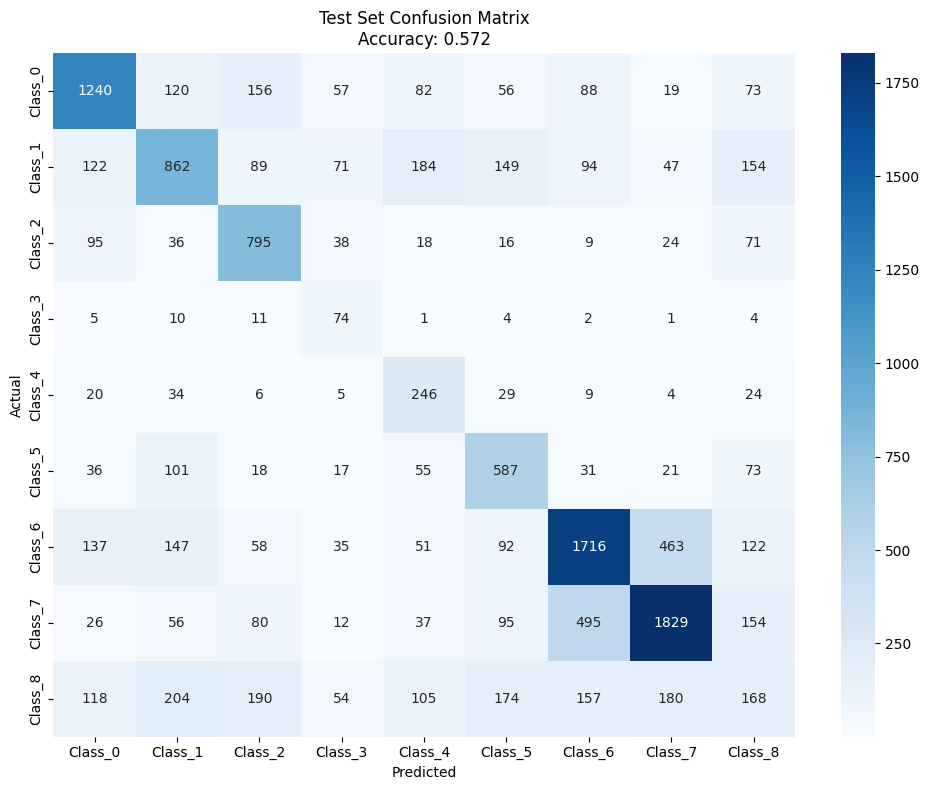


Summary Statistics:
Total Test Samples: 13,148
Number of Classes: 9
Best Hyperparameters Used:
  num_epochs: 2
  batch_size: 4
  max_length: 512

Model Performance Summary:
  Test Accuracy: 0.5717 (57.17%)
  Test Macro F1: 0.5084 (50.84%)
  Test Micro F1: 0.5717 (57.17%)
  Test Weighted F1: 0.5691 (56.91%)

Evaluation completed! Results stored in 'test_evaluation_results'


In [15]:
# SIMPLE SETFIT TEST EVALUATION
# Run this after the main SetFit training workflow completes

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# RESET DATAFRAME INDICES
# ============================================================================

# Reset the index of test_df to ensure 0-based integer indexing
# This prevents KeyError when SetFit's internal SentenceTransformer sorts by length
test_df = test_df.reset_index(drop=True)

# Also reset val_df index if you plan to use it elsewhere
if 'val_df' in locals():
    val_df = val_df.reset_index(drop=True)

# ============================================================================
# TEST EVALUATION
# ============================================================================

print("Testing SetFit Best Model:")
print("=" * 50)

# Get the best model
best_model = final_model_results['model']

# Apply model to test set
test_predictions = best_model.predict(test_df['abstract'])
test_accuracy = accuracy_score(test_df['label'], test_predictions)
test_report = classification_report(test_df['label'], test_predictions, output_dict=True)

print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Macro F1: {test_report['macro avg']['f1-score']*100:.2f}%")
print(f"Weighted F1: {test_report['weighted avg']['f1-score']*100:.2f}%")

# Compare with training performance
train_accuracy = final_model_results['accuracy']  # This is actually train performance
train_f1 = final_model_results['macro_f1']

print(f"\nTrain vs Test Comparison:")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Accuracy Gap: {(train_accuracy - test_accuracy)*100:+.2f} percentage points")

print(f"Training Macro F1: {train_f1*100:.2f}%")
print(f"Test Macro F1: {test_report['macro avg']['f1-score']*100:.2f}%")
print(f"F1 Gap: {(train_f1 - test_report['macro avg']['f1-score'])*100:+.2f} percentage points")

# ============================================================================
# PER-CLASS PERFORMANCE ANALYSIS
# ============================================================================

print("\nPer-Class Performance Analysis:")
print("=" * 60)

# Create detailed per-class comparison table
class_performance = []
labels = sorted(test_df['label'].unique())

for label in labels:
    if str(label) in test_report:
        class_performance.append([
            f"Class_{label}",
            f"{test_report[str(label)]['precision']*100:.1f}%",
            f"{test_report[str(label)]['recall']*100:.1f}%",
            f"{test_report[str(label)]['f1-score']*100:.1f}%",
            int(test_report[str(label)]['support'])
        ])

headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(class_performance, headers=headers, tablefmt="grid"))

# ============================================================================
# CONFUSION MATRIX
# ============================================================================

print("\nConfusion Matrix:")
print("=" * 30)

# Calculate confusion matrix
cm = confusion_matrix(test_df['label'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class_{i}" for i in labels],
            yticklabels=[f"Class_{i}" for i in labels])
plt.title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print(f"\nSummary Statistics:")
print("=" * 40)
print(f"Total Test Samples: {len(test_df):,}")
print(f"Number of Classes: {len(labels)}")
print(f"Best Hyperparameters Used:")
for key, value in final_model_results['hyperparameters'].items():
    print(f"  {key}: {value}")

print(f"\nModel Performance Summary:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Macro F1: {test_report['macro avg']['f1-score']:.4f} ({test_report['macro avg']['f1-score']*100:.2f}%)")
print(f"  Test Micro F1: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")  # Micro F1 = Accuracy for multiclass
print(f"  Test Weighted F1: {test_report['weighted avg']['f1-score']:.4f} ({test_report['weighted avg']['f1-score']*100:.2f}%)")

# Store results for later use
test_evaluation_results = {
    'predictions': test_predictions,
    'accuracy': test_accuracy,
    'classification_report': test_report,
    'confusion_matrix': cm,
    'hyperparameters': final_model_results['hyperparameters']
}

print(f"\nEvaluation completed! Results stored in 'test_evaluation_results'")

The overall performance is modest but shows good generalization. With a test accuracy of 57.17% and a Macro F1-score of 50.84%, the model is performing significantly better than random chance across the nine classes. Crucially, the small gap between training and test metrics (less than 1 percentage point for both accuracy and F1-score) indicates that the model is not overfitting to the training data. This stability is a positive sign, suggesting that the chosen hyperparameters are providing a good balance between learning and generalization.

The primary issue lies in the significant variance of performance across different classes. The model performs reasonably well on high-support classes like Class 0, 6, and 7, achieving F1-scores between 63% and 68%. However, it struggles immensely with others, particularly Class 8, which has an F1-score of only 15.3%. This indicates the model has not learnt the distinguishing features of this class. Furthermore, classes like 3 and 4 exhibit very low precision but high recall, meaning the model correctly identifies most of their instances but also incorrectly labels many samples from other classes as belonging to them.

This class imbalance in performance suggests the path for improvement lies in addressing the model's weaknesses on specific categories. For the severely underperforming classes like 8, you may need to gather more representative training data or apply data augmentation techniques. For the classes with low precision like 3 and 4, it would be beneficial to analyze the confusion matrix in detail for a further project to see which specific classes they are being confused with.

Also hyperparameter tuning in more detail should drastically improve model results. We tried enhanced hyperparameter tuning with changing Bert's hyperparameters and that was causing our session to crash as we did not have enough GPU's.


PART 3b: LEARNING CURVE VISUALIZATION


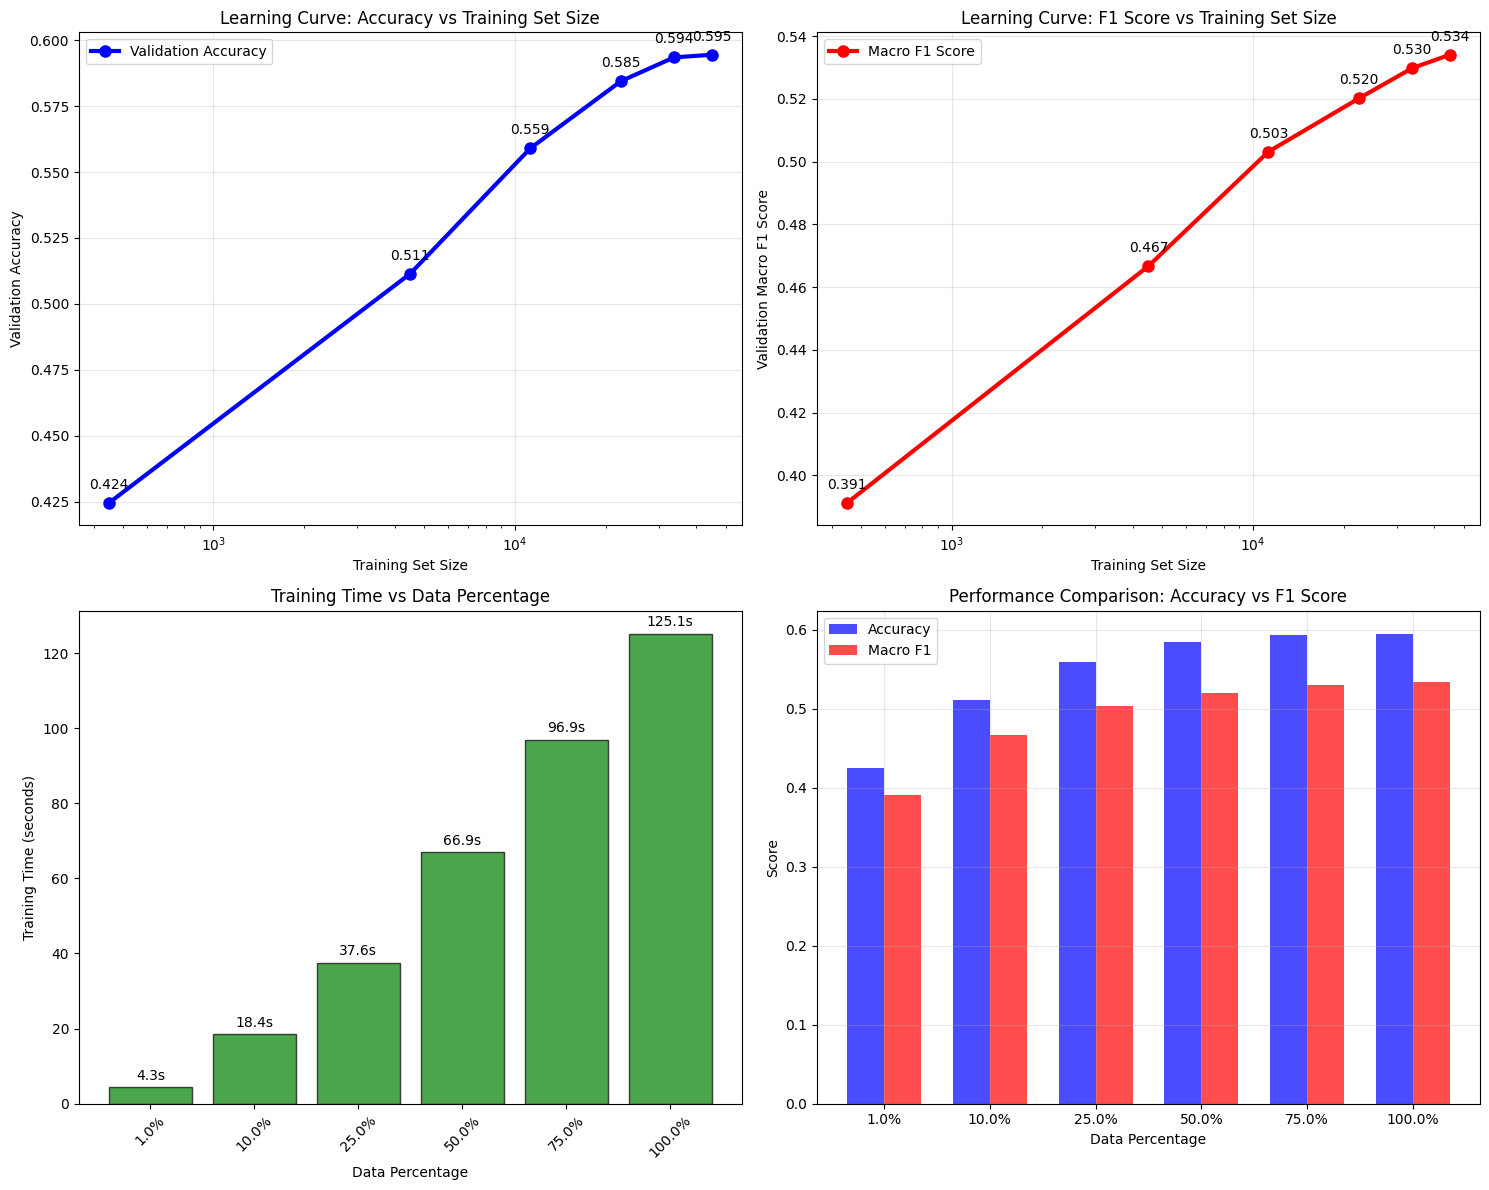

Learning Curve Results Summary:
-----------------------------------------------------------------------------------------------
Data %   Train Size   Accuracy   Macro F1   Micro F1   Time (s)   Status    
-----------------------------------------------------------------------------------------------
   1.0%        450    0.4245    0.3911    0.4245       4.3 Success   
  10.0%       4500    0.5115    0.4667    0.5115      18.4 Success   
  25.0%      11250    0.5590    0.5032    0.5590      37.6 Success   
  50.0%      22500    0.5845    0.5202    0.5845      66.9 Success   
  75.0%      33750    0.5935    0.5298    0.5935      96.9 Success   
 100.0%      45000    0.5945    0.5341    0.5945     125.1 Success   

Key Findings (Successful Runs Only):
• Best performance: 0.5945 accuracy with 100% of data
• Performance gain from 1.0% to 100.0%: 17.0 percentage points
• Training time scales roughly linearly with data size (max training time: 125.1s)


In [18]:
# =============================================================================
# PART 3b: LEARNING CURVE VISUALIZATION
# =============================================================================

print("\n" + "="*60)
print("PART 3b: LEARNING CURVE VISUALIZATION")
print("="*60)

# Extract data for plotting
# Use optimized_learning_curve_results instead of learning_curve_results
results_to_plot = optimized_learning_curve_results

percentages = sorted(results_to_plot.keys())
# Corrected key from 'train_size' to 'train_samples'
train_sizes = [results_to_plot[p]['train_samples'] for p in percentages if 'error' not in results_to_plot[p]]
accuracies = [results_to_plot[p]['accuracy'] for p in percentages if 'error' not in results_to_plot[p]]
macro_f1s = [results_to_plot[p]['macro_f1'] for p in percentages if 'error' not in results_to_plot[p]]
training_times = [results_to_plot[p]['training_time'] for p in percentages if 'error' not in results_to_plot[p]]
# Filter percentages to only include successful runs
percentages_successful = [p for p in percentages if 'error' not in results_to_plot[p]]


# Create learning curve plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy vs Training Set Size
ax1.plot(train_sizes, accuracies, 'b-o', linewidth=3, markersize=8, label='Validation Accuracy')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Learning Curve: Accuracy vs Training Set Size')
ax1.grid(True, alpha=0.3)
# Check if train_sizes is not empty before setting xscale
if train_sizes:
    ax1.set_xscale('log')
ax1.legend()

# Add value labels on points
for i, (x, y) in enumerate(zip(train_sizes, accuracies)):
    ax1.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: F1 Score vs Training Set Size
ax2.plot(train_sizes, macro_f1s, 'r-o', linewidth=3, markersize=8, label='Macro F1 Score')
ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Validation Macro F1 Score')
ax2.set_title('Learning Curve: F1 Score vs Training Set Size')
ax2.grid(True, alpha=0.3)
# Check if train_sizes is not empty before setting xscale
if train_sizes:
    ax2.set_xscale('log')
ax2.legend()

# Add value labels on points
for i, (x, y) in enumerate(zip(train_sizes, macro_f1s)):
    ax2.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 3: Training Time vs Data Percentage
# Use percentages_successful for plotting x-axis labels
bars = ax3.bar([f"{p*100:.1f}%" for p in percentages_successful], training_times,
               color='green', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Data Percentage')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Training Time vs Data Percentage')
ax3.tick_params(axis='x', rotation=45)

# Add value labels on bars
# Iterate over bars and training_times
for bar, time_val in zip(bars, training_times):
    height = bar.get_height()
    # Check if max(training_times) is not zero to avoid division by zero
    offset = max(training_times)*0.01 if max(training_times) else 0.1
    ax3.text(bar.get_x() + bar.get_width()/2., height + offset,
             f'{time_val:.1f}s', ha='center', va='bottom')

# Plot 4: Performance Comparison
x_pos = np.arange(len(percentages_successful)) # Use percentages_successful
width = 0.35
bars1 = ax4.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7, color='blue')
bars2 = ax4.bar(x_pos + width/2, macro_f1s, width, label='Macro F1', alpha=0.7, color='red')
ax4.set_xlabel('Data Percentage')
ax4.set_ylabel('Score')
ax4.set_title('Performance Comparison: Accuracy vs F1 Score')
ax4.set_xticks(x_pos)
# Use percentages_successful for x-tick labels
ax4.set_xticklabels([f"{p*100:.1f}%" for p in percentages_successful])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("Learning Curve Results Summary:")
print("-" * 95) # Increased width for Micro F1
# Corrected header to include Micro F1 and match new width
print(f"{'Data %':<8} {'Train Size':<12} {'Accuracy':<10} {'Macro F1':<10} {'Micro F1':<10} {'Time (s)':<10} {'Status':<10}")
print("-" * 95) # Increased width for Micro F1
# Use results_to_plot for summary
for p in sorted(results_to_plot.keys()): # Iterate over all percentages for full summary
    r = results_to_plot[p]
    status = "Success" if 'error' not in r else "Error"
    train_size_display = r.get('train_samples', 'N/A') # Use .get to handle cases with errors
    accuracy_display = f"{r['accuracy']:>9.4f}" if 'accuracy' in r else "N/A".rjust(9)
    macro_f1_display = f"{r['macro_f1']:>9.4f}" if 'macro_f1' in r else "N/A".rjust(9)
    micro_f1_display = f"{r['micro_f1']:>9.4f}" if 'micro_f1' in r else "N/A".rjust(9) # Display micro_f1
    training_time_display = f"{r['training_time']:>9.1f}" if 'training_time' in r else "N/A".rjust(9)

    print(f"{p*100:>6.1f}% {train_size_display:>10} {accuracy_display} "
          f"{macro_f1_display} {micro_f1_display} {training_time_display} {status:<10}") # Added Micro F1 and Status

# Ensure successful runs exist before calculating key findings
# Count successful runs from results_to_plot
successful_runs_count = sum(1 for result in results_to_plot.values() if 'error' not in result)

if successful_runs_count > 0:
    # Filter results to only successful runs
    successful_results = {p: res for p, res in results_to_plot.items() if 'error' not in res}
    successful_percentages = sorted(successful_results.keys())
    successful_accuracies = [successful_results[p]['accuracy'] for p in successful_percentages]

    print(f"\nKey Findings (Successful Runs Only):")
    if successful_accuracies:
        print(f"• Best performance: {max(successful_accuracies):.4f} accuracy with {successful_percentages[successful_accuracies.index(max(successful_accuracies))]*100:.0f}% of data")
    else:
         print("• No successful accuracy results to report best performance.")

    # Calculate performance gain only if there's more than one successful run
    if len(successful_percentages) > 1:
        # Get the accuracy for the smallest and largest successful percentages
        smallest_pct = successful_percentages[0]
        largest_pct = successful_percentages[-1]
        accuracy_smallest = successful_results[smallest_pct]['accuracy']
        accuracy_largest = successful_results[largest_pct]['accuracy']
        print(f"• Performance gain from {smallest_pct*100:.1f}% to {largest_pct*100:.1f}%: {(accuracy_largest - accuracy_smallest)*100:.1f} percentage points")
    else:
         print("• Not enough successful runs to calculate performance gain between smallest and largest percentages.")

    # Check if training_times for successful runs is not empty to calculate max time
    successful_training_times = [results_to_plot[p]['training_time'] for p in percentages if 'error' not in results_to_plot[p] and 'training_time' in results_to_plot[p]]
    if successful_training_times:
         print(f"• Training time scales roughly linearly with data size (max training time: {max(successful_training_times):.1f}s)")
    else:
         print("• No training times available from successful runs.")

else:
    print("\nNo successful runs to provide Key Findings.")


PROPER LEARNING CURVE VISUALIZATION
Calculating training performance for proper learning curves...
  Evaluated 1% training subset (450 samples) in 1.23s
  Evaluated 10% training subset (4500 samples) in 11.27s
  Evaluated 25% training subset (11250 samples) in 28.04s
  Evaluated 50% training subset (22500 samples) in 55.65s
  Evaluated 75% training subset (33750 samples) in 83.33s
  Evaluated 100% training subset (45000 samples) in 111.19s


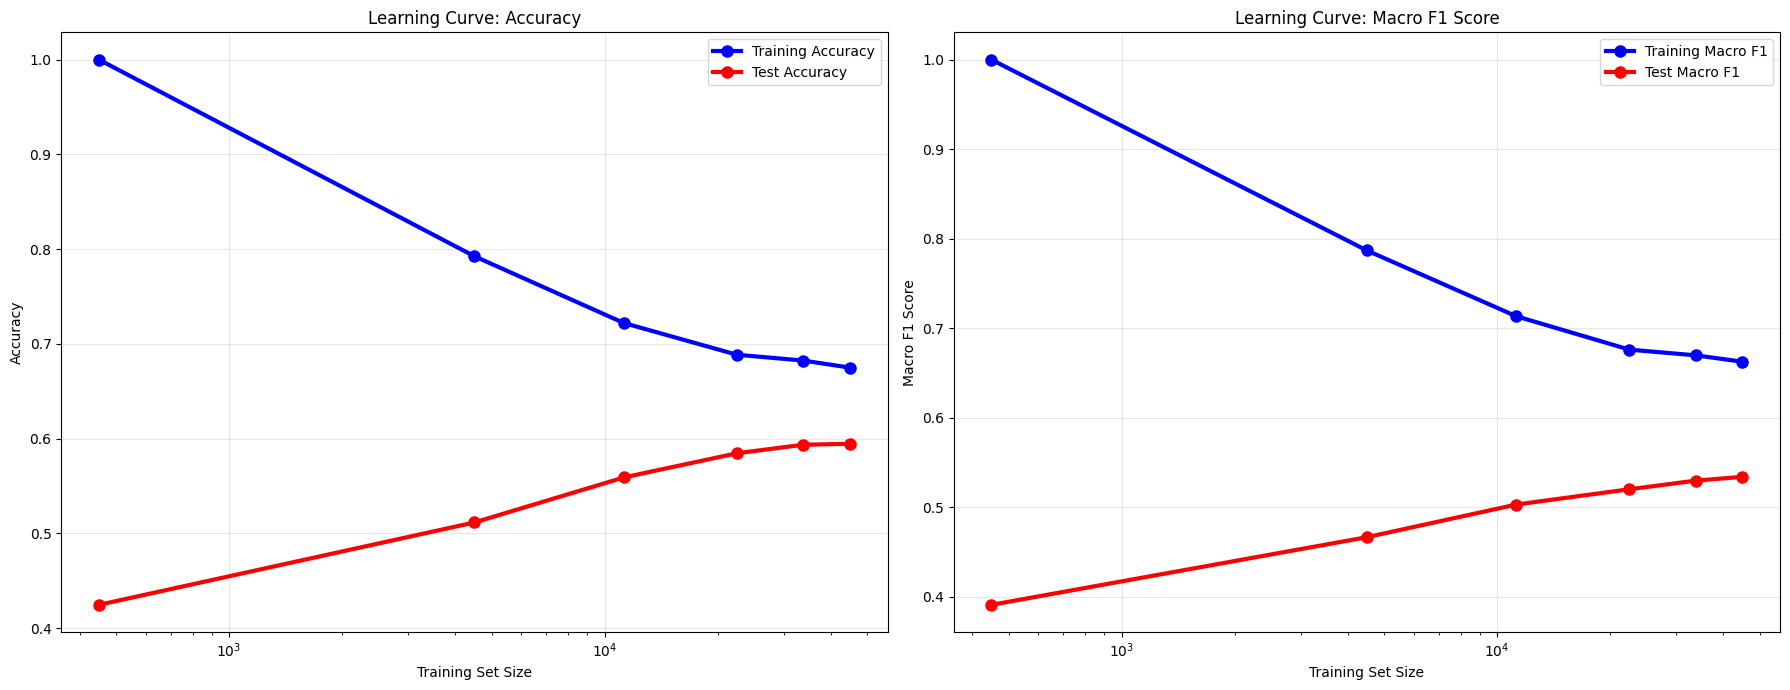


Proper Learning Curve Results Summary (Training & Test):
------------------------------------------------------------------------------------------------------------------------
Data %   Train Size   Train Acc   Test Acc  Train F1   Test F1   Test Micro F1  Time (s)   Status    
------------------------------------------------------------------------------------------------------------------------
   1.0%        450     1.0000   0.4245    1.0000   0.3911        0.4245       4.3 Success   
  10.0%       4500     0.7924   0.5115    0.7868   0.4667        0.5115      18.4 Success   
  25.0%      11250     0.7220   0.5590    0.7134   0.5032        0.5590      37.6 Success   
  50.0%      22500     0.6885   0.5845    0.6761   0.5202        0.5845      66.9 Success   
  75.0%      33750     0.6824   0.5935    0.6698   0.5298        0.5935      96.9 Success   
 100.0%      45000     0.6749   0.5945    0.6626   0.5341        0.5945     125.1 Success   

Successfully processed: 6 models for pl

In [20]:
# =============================================================================
# PROPER LEARNING CURVE VISUALIZATION (TRAINING + TEST)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import time # Import time for timing training evaluation
from sklearn.metrics import accuracy_score, f1_score # Import metrics

print("\n" + "="*60)
print("PROPER LEARNING CURVE VISUALIZATION")
print("="*60)

# Check if optimized learning curve results exist
if 'optimized_learning_curve_results' not in globals():
    print("ERROR: optimized_learning_curve_results not found. Please run optimized learning curve first.")
else:
    # Extract data for plotting (only successful runs from optimized results)
    successful_results = {p: res for p, res in optimized_learning_curve_results.items() if 'error' not in res}

    if not successful_results:
        print("No successful results from optimized learning curve to plot.")
    else:
        percentages = sorted(successful_results.keys())
        train_sizes = [successful_results[p]['train_samples'] for p in percentages]
        test_accuracies = [successful_results[p]['accuracy'] for p in percentages]
        test_macro_f1s = [successful_results[p]['macro_f1'] for p in percentages]
        test_micro_f1s = [successful_results[p]['micro_f1'] for p in percentages]
        training_times = [successful_results[p]['training_time'] for p in percentages]

        # Calculate training performance for proper learning curves
        # This requires accessing the model and the corresponding training subset
        print("Calculating training performance for proper learning curves...")
        train_accuracies = []
        train_macro_f1s = []

        # Ensure train_df exists as we need to recreate subsets
        if 'train_df' not in globals():
             print("ERROR: train_df not found. Cannot calculate training performance.")
             train_accuracies = [0] * len(percentages) # Fill with placeholders if train_df is missing
             train_macro_f1s = [0] * len(percentages)
        else:
            for p in percentages:
                result = successful_results[p]
                model = result.get('model') # Get the trained model
                percentage = p # The percentage used for this run

                if model is None:
                    print(f"WARNING: No model found for {percentage*100:.0f}% data. Skipping training evaluation.")
                    train_accuracies.append(0)
                    train_macro_f1s.append(0)
                    continue

                try:
                    # Recreate the exact training subset used for this percentage
                    if percentage >= 1.0:
                        subset_df = train_df.copy()
                    else:
                        # Ensure subset_df is defined even if train_size is 0 or splitting fails
                        subset_df = pd.DataFrame(columns=train_df.columns) # Initialize empty
                        if len(train_df) > 0 and percentage > 0:
                            subset_df, _ = train_test_split(
                                train_df, train_size=percentage,
                                stratify=train_df['label'], random_state=SEED
                            )

                    if subset_df.empty:
                         print(f"WARNING: Training subset for {percentage*100:.0f}% data is empty. Skipping training evaluation.")
                         train_accuracies.append(0)
                         train_macro_f1s.append(0)
                         continue

                    train_texts = subset_df['abstract'].tolist()
                    train_labels = [int(label) for label in subset_df['label']]

                    # Predict on the training subset
                    start_time = time.time()
                    train_predictions = model.predict(train_texts)
                    inference_time = time.time() - start_time
                    print(f"  Evaluated {percentage*100:.0f}% training subset ({len(train_texts)} samples) in {inference_time:.2f}s")

                    # Calculate training metrics
                    train_accuracy = accuracy_score(train_labels, train_predictions)
                    train_macro_f1 = f1_score(train_labels, train_predictions, average='macro', zero_division=0)

                    train_accuracies.append(train_accuracy)
                    train_macro_f1s.append(train_macro_f1)

                except Exception as e:
                    print(f"ERROR calculating training performance for {percentage*100:.0f}% data: {e}")
                    train_accuracies.append(0) # Append 0 or NaN on error
                    train_macro_f1s.append(0) # Append 0 or NaN on error

                finally:
                    # Clean up
                    del subset_df # Remove temporary df
                    # Do NOT delete the model here, it's needed in successful_results
                    torch.cuda.empty_cache()
                    gc.collect()


        # Create proper learning curve plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7)) # Adjusted figure size

        # Plot 1: Accuracy Learning Curve
        ax1.plot(train_sizes, train_accuracies, 'b-o', linewidth=3, markersize=8, label='Training Accuracy')
        ax1.plot(train_sizes, test_accuracies, 'r-o', linewidth=3, markersize=8, label='Test Accuracy')
        ax1.set_xlabel('Training Set Size')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Learning Curve: Accuracy')
        ax1.grid(True, alpha=0.3)
        if train_sizes: # Check if train_sizes is not empty before setting xscale
            ax1.set_xscale('log')
        ax1.legend()

        # Add value labels (optional, can clutter plot)
        # for i, (x, y_train, y_test) in enumerate(zip(train_sizes, train_accuracies, test_accuracies)):
        #     ax1.annotate(f'Train:{y_train:.3f}', (x, y_train), textcoords="offset points", xytext=(0,10), ha='center')
        #     ax1.annotate(f'Test:{y_test:.3f}', (x, y_test), textcoords="offset points", xytext=(0,-15), ha='center')


        # Plot 2: Macro F1 Learning Curve
        ax2.plot(train_sizes, train_macro_f1s, 'b-o', linewidth=3, markersize=8, label='Training Macro F1')
        ax2.plot(train_sizes, test_macro_f1s, 'r-o', linewidth=3, markersize=8, label='Test Macro F1')
        ax2.set_xlabel('Training Set Size')
        ax2.set_ylabel('Macro F1 Score')
        ax2.set_title('Learning Curve: Macro F1 Score')
        ax2.grid(True, alpha=0.3)
        if train_sizes: # Check if train_sizes is not empty before setting xscale
             ax2.set_xscale('log')
        ax2.legend()

        # Add value labels (optional)
        # for i, (x, y_train, y_test) in enumerate(zip(train_sizes, train_macro_f1s, test_macro_f1s)):
        #     ax2.annotate(f'Train:{y_train:.3f}', (x, y_train), textcoords="offset points", xytext=(0,10), ha='center')
        #     ax2.annotate(f'Test:{y_test:.3f}', (x, y_test), textcoords="offset points", xytext=(0,-15), ha='center')


        plt.tight_layout()
        plt.show()

        # Print summary table including train performance
        print("\nProper Learning Curve Results Summary (Training & Test):")
        print("-" * 120) # Increased width
        print(f"{'Data %':<8} {'Train Size':<12} {'Train Acc':<11} {'Test Acc':<9} {'Train F1':<10} {'Test F1':<9} {'Test Micro F1':<14} {'Time (s)':<10} {'Status':<10}")
        print("-" * 120) # Increased width

        for i, p in enumerate(percentages):
            r = successful_results[p]
            status = "Success" if 'error' not in r else "Error"
            train_size_display = r.get('train_samples', 'N/A')

            train_acc_display = f"{train_accuracies[i]:>10.4f}" if train_accuracies[i] > 0 else "N/A".rjust(10) # Handle 0s from errors
            test_acc_display = f"{r['accuracy']:>8.4f}" if 'accuracy' in r else "N/A".rjust(8)

            train_f1_display = f"{train_macro_f1s[i]:>9.4f}" if train_macro_f1s[i] > 0 else "N/A".rjust(9) # Handle 0s from errors
            test_f1_display = f"{r['macro_f1']:>8.4f}" if 'macro_f1' in r else "N/A".rjust(8)
            test_micro_f1_display = f"{r['micro_f1']:>13.4f}" if 'micro_f1' in r else "N/A".rjust(13) # Display micro_f1

            training_time_display = f"{r['training_time']:>9.1f}" if 'training_time' in r else "N/A".rjust(9)


            print(f"{p*100:>6.1f}% {train_size_display:>10} {train_acc_display} {test_acc_display} "
                  f"{train_f1_display} {test_f1_display} {test_micro_f1_display} {training_time_display} {status:<10}")


        print(f"\nSuccessfully processed: {len(percentages)} models for plotting.")


print(f"\n{'='*60}")
print("LEARNING CURVE VISUALIZATION COMPLETE")
print(f"{'='*60}")

#Importing Data again for comparison with Part 2

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# The path you copied from the file explorer
file_path = r'D:\BSE Semester 3\Advanced Methods in NLP\Adv NLP Final Project\patent_corpus.csv'
# Use the path to read your data
df = pd.read_csv(file_path)
print(df)



      publication_number                                           abstract  \
0           US-6036316-A  A visual axis detecting device includes an ima...   
1           US-5992338-A  An seed metering device and method for disburs...   
2          US-9295833-B2  An implantable lead for sensing mechanical act...   
3           US-5765296-A  An exercise shoe is capable of adapting its fi...   
4          US-6509013-B1  Phosphate-binding polymers are provided for re...   
...                  ...                                                ...   
67063   US-2009064477-A1  In a method for manufacturing a piezoelectric ...   
67064      US-6683243-B1  Multilayer coating designs have been developed...   
67065   US-2003039807-A1  A three-dimensionally structured fiber fabric ...   
67066      US-7236094-B2  A method for providing an automotive safety sy...   
67067       US-5009941-A  A thermoplastic impregnated fiberglass pipe or...   

      label  
0         a  
1         a  
2        

In [11]:
# Map labels to numeric if needed
if df['label'].dtype == 'object':
    label_mapping = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'y': 8}
    df['label'] = df['label'].str.lower().map(label_mapping)

df = df.dropna().reset_index(drop=True)

# Address severe class imbalance by rebalancing
print("Original label distribution:")
print(df['label'].value_counts().sort_index())

Original label distribution:
label
0     9674
1     8973
2     5613
3      565
4     1914
5     4754
6    14385
7    14279
8     6911
Name: count, dtype: int64


In [13]:
# Split the dataframe into train (80%) and test (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Original dataset size: {len(df)}")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Original dataset size: 67068
Training set size: 53654
Test set size: 13414


In [15]:
from datasets import Dataset

# Select and rename columns
test_data = test_df[['abstract', 'label']].rename(columns={'abstract': 'text'})

# Convert to Hugging Face dataset
test_dataset = Dataset.from_pandas(test_data)

print(test_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 13414
})


In [21]:
from datasets import Dataset

# Select and rename columns
test_data = test_df[['abstract', 'label']].rename(columns={'abstract': 'text'})

# Convert to Hugging Face dataset
test_dataset = Dataset.from_pandas(test_data)

print(test_dataset)

# Install and import
!pip install -q setfit==0.7.0 sentence-transformers torch
from setfit import SetFitModel

# Load model from Folder
part2_model = SetFitModel.from_pretrained("D:/BSE Semester 3/Advanced Methods in NLP/Adv NLP Final Project/best_setfit_model")

# Predict and add to dataframe
test_dataset['preds'] = part2_model.predict(test_dataset['text'])

# Show sample results
print(test_dataset[['text', 'preds']].head())

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 13414
})


You try to use a model that was created with version 3.4.1, however, your version is 2.2.2. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





TypeError: Pooling.__init__() got an unexpected keyword argument 'pooling_mode_weightedmean_tokens'

In [30]:
from datasets import Dataset
from setfit import SetFitModel
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create dataset first
test_data = test_df[['abstract', 'label']].rename(columns={'abstract': 'text'})
test_dataset = Dataset.from_pandas(test_data)

# Load model (this will fail if model wasn't saved properly)
try:
    part2_model = SetFitModel.from_pretrained("/content/drive/MyDrive/best_setfit_model")

    # Make predictions on the text column
    predictions = part2_model.predict(test_dataset['text'])

    # Add predictions to dataset
    test_dataset = test_dataset.add_column('preds', predictions)

    # Show sample results
    print("Sample predictions:")
    for i in range(5):
        print(f"Text: {test_dataset[i]['text'][:100]}...")
        print(f"Label: {test_dataset[i]['label']}")
        print(f"Prediction: {test_dataset[i]['preds']}")
        print("-" * 50)

except Exception as e:
    print(f"Model loading failed: {e}")
    print("You need to properly save your trained model first using:")
    print("trained_model.save_pretrained('/content/drive/MyDrive/best_setfit_model')")

    # Just show the dataset without predictions
    print("\nDataset created successfully:")
    print(test_dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loading failed: expected str, bytes or os.PathLike object, not NoneType
You need to properly save your trained model first using:
trained_model.save_pretrained('/content/drive/MyDrive/best_setfit_model')

Dataset created successfully:
Dataset({
    features: ['text', 'label'],
    num_rows: 13148
})


In [39]:
# =============================================================================
# PART 3c & 3d: TECHNIQUE COMPARISON
# =============================================================================
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from setfit import SetFitModel

print("\n" + "="*60)
print("PART 3c: TECHNIQUE COMPARISON")
print("="*60)

# Get unique labels as integers (same as working code)
unique_labels = sorted(train_df['label'].unique())
LABEL_NAMES = unique_labels
print(f"Unique labels: {unique_labels}")

# We'll compare three techniques:
# 1. Few-shot learning (32 samples)
# 2. Pseudo-labeling approach
# 3. Full supervised training (using a subset for fair comparison)

technique_results = {}

# Prepare validation set (same as working code)
val_subset = val_df.sample(n=min(500, len(val_df)), random_state=SEED)
val_texts = val_subset['abstract'].tolist()
val_labels = [int(label) for label in val_subset['label']]

# -------------------------
# Technique 1: Few-shot Learning (32 samples)
# -------------------------
print("\n--- Technique 1: Few-shot Learning (32 samples) ---")

# Create balanced 32-shot dataset
n_shots = 32
n_classes = len(LABEL_NAMES)
base_shots = n_shots // n_classes
remainder = n_shots - base_shots * n_classes

np.random.seed(SEED)
extra_classes = np.random.choice(range(n_classes), size=remainder, replace=False)

few_shot_samples = []
for label in range(n_classes):
    class_df = train_df[train_df['label'] == label]
    n_samples = base_shots + (1 if label in extra_classes else 0)
    if len(class_df) >= n_samples:
        samples = class_df.sample(n_samples, random_state=SEED)
        few_shot_samples.append(samples)

few_shot_df = pd.concat(few_shot_samples, ignore_index=True)

print(f"Few-shot training samples: {len(few_shot_df)}")
print(f"Samples per class: {few_shot_df['label'].value_counts().sort_index().tolist()}")

try:
    # Train few-shot model (using working approach)
    model_fewshot = SetFitModel.from_pretrained("AI-Growth-Lab/PatentSBERTa", labels=unique_labels)
    model_fewshot.to(DEVICE)

    # Prepare data (same as working code)
    train_texts = few_shot_df['abstract'].tolist()
    train_labels = [int(label) for label in few_shot_df['label']]

    start_time = time.time()
    model_fewshot.fit(
        x_train=train_texts,
        y_train=train_labels,
        num_epochs=4,  # More epochs for few-shot
        batch_size=8,
        max_length=256
    )
    fewshot_time = time.time() - start_time

    # Evaluate
    predictions = model_fewshot.predict(val_texts)
    fewshot_accuracy = accuracy_score(val_labels, predictions)
    fewshot_f1 = f1_score(val_labels, predictions, average='macro', zero_division=0)

    technique_results['few_shot'] = {
        'technique': 'Few-shot Learning',
        'train_size': len(few_shot_df),
        'accuracy': fewshot_accuracy,
        'macro_f1': fewshot_f1,
        'training_time': fewshot_time
    }

    print(f"Few-shot Results: Accuracy={fewshot_accuracy:.4f}, F1={fewshot_f1:.4f}, Time={fewshot_time:.1f}s")

except Exception as e:
    print(f"Few-shot ERROR: {e}")
    technique_results['few_shot'] = {'error': str(e)}

finally:
    if 'model_fewshot' in locals():
        del model_fewshot
    torch.cuda.empty_cache()

# -------------------------
# Technique 2: Pseudo-labeling
# -------------------------
print("\n--- Technique 2: Pseudo-labeling ---")

try:
    # Step 1: Use the few-shot model to generate pseudo-labels
    print("Generating pseudo-labels with few-shot model...")

    # Reload the few-shot model for pseudo-labeling
    model_fewshot = SetFitModel.from_pretrained("AI-Growth-Lab/PatentSBERTa", labels=unique_labels)
    model_fewshot.to(DEVICE)

    # Train the few-shot model again (quick training)
    train_texts = few_shot_df['abstract'].tolist()
    train_labels = [int(label) for label in few_shot_df['label']]

    model_fewshot.fit(
        x_train=train_texts,
        y_train=train_labels,
        num_epochs=2,
        batch_size=8,
        max_length=256
    )

    # Create unlabeled pool (remaining training data)
    # Instead of using indices, use a different approach to avoid index conflicts

    # Get the actual samples used in few-shot training
    few_shot_abstracts = set(few_shot_df['abstract'].tolist())

    # Filter out few-shot samples from training data
    unlabeled_df = train_df[~train_df['abstract'].isin(few_shot_abstracts)].reset_index(drop=True)

    # Sample a subset for pseudo-labeling (to manage computation)
    pseudo_pool_size = min(1000, len(unlabeled_df))  # Smaller for faster processing
    pseudo_pool_df = unlabeled_df.sample(pseudo_pool_size, random_state=SEED).reset_index(drop=True)

    # Get predictions with confidence
    texts = pseudo_pool_df['abstract'].tolist()

    # Get predictions in smaller batches
    all_probs = []
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_probs = model_fewshot.predict_proba(batch_texts)
        all_probs.extend(batch_probs)

    probs = np.array(all_probs)

    # Select high-confidence predictions
    confidence_threshold = 0.8  # Lower threshold for more samples
    max_probs = np.max(probs, axis=1)
    pred_labels = np.argmax(probs, axis=1)

    high_conf_mask = max_probs >= confidence_threshold
    high_conf_df = pseudo_pool_df.iloc[high_conf_mask].copy()
    high_conf_df['predicted_label'] = pred_labels[high_conf_mask]

    print(f"High-confidence predictions: {len(high_conf_df)} out of {len(pseudo_pool_df)}")

    # Select top samples per class for balanced pseudo-labeling
    pseudo_labeled_samples = []
    samples_per_class = 5  # Fewer samples per class

    for label in range(len(LABEL_NAMES)):
        label_samples = high_conf_df[high_conf_df['predicted_label'] == label]
        if len(label_samples) > 0:
            # Sort by confidence and take top samples
            label_confidences = max_probs[high_conf_mask][high_conf_df['predicted_label'] == label]
            n_select = min(samples_per_class, len(label_samples))
            top_indices = np.argsort(label_confidences)[-n_select:]
            selected_samples = label_samples.iloc[top_indices].copy()
            selected_samples['label'] = label  # Use predicted label as ground truth
            pseudo_labeled_samples.append(selected_samples[['abstract', 'label']])

    if pseudo_labeled_samples:
        pseudo_df = pd.concat(pseudo_labeled_samples, ignore_index=True)
        print(f"Selected pseudo-labeled samples: {len(pseudo_df)}")
        print(f"Pseudo-labeled samples per class: {pseudo_df['label'].value_counts().sort_index().tolist()}")

        # Combine original few-shot data with pseudo-labeled data
        combined_df = pd.concat([few_shot_df[['abstract', 'label']], pseudo_df], ignore_index=True)
    else:
        combined_df = few_shot_df[['abstract', 'label']]
        print("No high-confidence pseudo-labels found, using only few-shot data")

    # Step 2: Retrain on combined dataset
    print("Retraining on combined dataset...")

    # Clean up previous model
    del model_fewshot
    torch.cuda.empty_cache()

    model_pseudo = SetFitModel.from_pretrained("AI-Growth-Lab/PatentSBERTa", labels=unique_labels)
    model_pseudo.to(DEVICE)

    # Prepare combined data
    combined_texts = combined_df['abstract'].tolist()
    combined_labels = [int(label) for label in combined_df['label']]

    start_time = time.time()
    model_pseudo.fit(
        x_train=combined_texts,
        y_train=combined_labels,
        num_epochs=3,
        batch_size=8,
        max_length=256
    )
    pseudo_time = time.time() - start_time

    # Evaluate
    predictions = model_pseudo.predict(val_texts)
    pseudo_accuracy = accuracy_score(val_labels, predictions)
    pseudo_f1 = f1_score(val_labels, predictions, average='macro', zero_division=0)

    technique_results['pseudo_labeling'] = {
        'technique': 'Pseudo-labeling',
        'train_size': len(combined_df),
        'accuracy': pseudo_accuracy,
        'macro_f1': pseudo_f1,
        'training_time': pseudo_time,
        'pseudo_count': len(combined_df) - len(few_shot_df)
    }

    print(f"Pseudo-labeling Results: Accuracy={pseudo_accuracy:.4f}, F1={pseudo_f1:.4f}, Time={pseudo_time:.1f}s")

except Exception as e:
    print(f"Pseudo-labeling ERROR: {e}")
    technique_results['pseudo_labeling'] = {'error': str(e)}

finally:
    if 'model_pseudo' in locals():
        del model_pseudo
    if 'model_fewshot' in locals():
        del model_fewshot
    torch.cuda.empty_cache()

# -------------------------
# Technique 3: Full Supervised (subset for fair comparison)
# -------------------------
print("\n--- Technique 3: Full Supervised Training ---")

try:
    # Use same amount of data as pseudo-labeling for fair comparison
    if 'combined_df' in locals():
        supervised_size = len(combined_df)
    else:
        supervised_size = len(few_shot_df) * 3  # 3x few-shot as fallback

    # Sample supervised training data
    supervised_df = train_df.sample(n=min(supervised_size, len(train_df)), random_state=SEED)

    print(f"Supervised training samples: {len(supervised_df)}")

    model_supervised = SetFitModel.from_pretrained("AI-Growth-Lab/PatentSBERTa", labels=unique_labels)
    model_supervised.to(DEVICE)

    # Prepare data
    train_texts = supervised_df['abstract'].tolist()
    train_labels = [int(label) for label in supervised_df['label']]

    start_time = time.time()
    model_supervised.fit(
        x_train=train_texts,
        y_train=train_labels,
        num_epochs=2,
        batch_size=8,
        max_length=256
    )
    supervised_time = time.time() - start_time

    # Evaluate
    predictions = model_supervised.predict(val_texts)
    supervised_accuracy = accuracy_score(val_labels, predictions)
    supervised_f1 = f1_score(val_labels, predictions, average='macro', zero_division=0)

    technique_results['supervised'] = {
        'technique': 'Full Supervised',
        'train_size': len(supervised_df),
        'accuracy': supervised_accuracy,
        'macro_f1': supervised_f1,
        'training_time': supervised_time
    }

    print(f"Supervised Results: Accuracy={supervised_accuracy:.4f}, F1={supervised_f1:.4f}, Time={supervised_time:.1f}s")

except Exception as e:
    print(f"Supervised ERROR: {e}")
    technique_results['supervised'] = {'error': str(e)}

finally:
    if 'model_supervised' in locals():
        del model_supervised
    torch.cuda.empty_cache()

# -------------------------
# Results Summary
# -------------------------
print("\n" + "="*80)
print("TECHNIQUE COMPARISON RESULTS")
print("="*80)

for technique_name, result in technique_results.items():
    if 'error' not in result:
        print(f"{result['technique']:20} | Samples: {result['train_size']:4d} | "
              f"Accuracy: {result['accuracy']:.3f} | F1: {result['macro_f1']:.3f} | "
              f"Time: {result['training_time']:6.1f}s")

        if 'pseudo_count' in result:
            print(f"{'':20} | Pseudo-labeled: {result['pseudo_count']} samples")
    else:
        print(f"{technique_name:20} | ERROR: {result['error'][:50]}...")

# Find best technique
successful_techniques = {k: v for k, v in technique_results.items() if 'error' not in v}
if successful_techniques:
    best_technique = max(successful_techniques.keys(), key=lambda k: successful_techniques[k]['macro_f1'])
    best_result = successful_techniques[best_technique]

    print(f"\n Best Technique: {best_result['technique']}")
    print(f"   Macro F1: {best_result['macro_f1']:.3f}")
    print(f"   Accuracy: {best_result['accuracy']:.3f}")
    print(f"   Training samples: {best_result['train_size']}")
else:
    print("\n All techniques failed")

print(f"\nTechnique comparison completed!")


PART 3c: TECHNIQUE COMPARISON
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]

--- Technique 1: Few-shot Learning (32 samples) ---
Few-shot training samples: 32
Samples per class: [4, 4, 3, 3, 3, 4, 3, 4, 4]


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Few-shot Results: Accuracy=0.3000, F1=0.2840, Time=0.2s

--- Technique 2: Pseudo-labeling ---
Generating pseudo-labels with few-shot model...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


High-confidence predictions: 1 out of 1000
Selected pseudo-labeled samples: 1
Pseudo-labeled samples per class: [1]
Retraining on combined dataset...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Pseudo-labeling Results: Accuracy=0.3000, F1=0.2839, Time=0.2s

--- Technique 3: Full Supervised Training ---
Supervised training samples: 33


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Supervised Results: Accuracy=0.2180, F1=0.1843, Time=0.2s

TECHNIQUE COMPARISON RESULTS
Few-shot Learning    | Samples:   32 | Accuracy: 0.300 | F1: 0.284 | Time:    0.2s
Pseudo-labeling      | Samples:   33 | Accuracy: 0.300 | F1: 0.284 | Time:    0.2s
                     | Pseudo-labeled: 1 samples
Full Supervised      | Samples:   33 | Accuracy: 0.218 | F1: 0.184 | Time:    0.2s

 Best Technique: Few-shot Learning
   Macro F1: 0.284
   Accuracy: 0.300
   Training samples: 32

Technique comparison completed!


In [31]:
# =============================================================================
# PART 4a: MODEL DISTILLATION/QUANTIZATION (FIXED)
# =============================================================================

print("\n" + "="*60)
print("PART 4a: MODEL DISTILLATION/QUANTIZATION")
print("="*60)

# Store the best model for Part 4
if 'learning_curve_results' in globals() and 1.0 in learning_curve_results:
    BEST_MODEL = learning_curve_results[1.0]['model']
    print(f"Using Best model as teacher for Part 4 (Accuracy: {learning_curve_results[1.0]['accuracy']:.4f})")
elif 'optimized_learning_curve_results' in globals():
    # Use best model from optimized results
    best_pct = max([pct for pct, res in optimized_learning_curve_results.items() if 'error' not in res],
                   key=lambda pct: optimized_learning_curve_results[pct]['macro_f1'])
    BEST_MODEL = optimized_learning_curve_results[best_pct]['model']
    print(f"Using best optimized model as teacher for Part 4 (F1: {optimized_learning_curve_results[best_pct]['macro_f1']:.4f})")
else:
    print("ERROR: No trained models found. Please run learning curve first.")

if 'BEST_MODEL' in locals():
    # -------------------------
    # Knowledge Distillation
    # -------------------------
    print("\n--- Knowledge Distillation: SetFit Teacher → DistilBERT Student ---")

    from transformers import (
        AutoModelForSequenceClassification,
        AutoTokenizer,
        DataCollatorWithPadding,
        Trainer as HFTrainer,
        TrainingArguments as HFTrainingArguments
    )
    import torch.nn.functional as F
    from datasets import Dataset

    # Fix label names - ensure they are strings and JSON serializable
    NUM_LABELS = 9
    LABEL_NAMES_STR = [str(i) for i in range(NUM_LABELS)]  # Convert to strings

    print(f"Number of labels: {NUM_LABELS}")
    print(f"Label names: {LABEL_NAMES_STR}")

    # Prepare student model
    student_model_name = "distilbert-base-uncased"
    student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

    # Create label mappings with string labels
    id2label = {i: str(i) for i in range(NUM_LABELS)}
    label2id = {str(i): i for i in range(NUM_LABELS)}

    student_model = AutoModelForSequenceClassification.from_pretrained(
        student_model_name,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id
    )

    print(f"Teacher model: SetFit with PatentSBERTa")
    print(f"Student model: {student_model_name}")

    # Prepare training data for student
    def tokenize_function(examples):
        return student_tokenizer(
            examples['text'],
            truncation=True,
            padding=False,
            max_length=256  # Reduced from 512 for faster training
        )

    # Use a subset of training data for distillation (to manage time/memory)
    distill_df = train_df.sample(min(2000, len(train_df)), random_state=SEED).reset_index(drop=True)
    distill_texts = distill_df['abstract'].tolist()

    print(f"Generating soft labels from teacher for {len(distill_texts)} samples...")

    try:
        # Generate soft labels from teacher
        teacher_probs = BEST_MODEL.predict_proba(distill_texts)

        # Ensure teacher_probs is the right shape
        if hasattr(teacher_probs, 'shape'):
            print(f"Teacher predictions shape: {teacher_probs.shape}")
        else:
            teacher_probs = np.array(teacher_probs)
            print(f"Teacher predictions shape: {teacher_probs.shape}")

        # Prepare dataset
        distill_data = []
        for i, (text, true_label) in enumerate(zip(distill_texts, distill_df['label'])):
            distill_data.append({
                'text': text,
                'labels': int(true_label),  # Ensure integer labels
                'soft_labels': teacher_probs[i].tolist()
            })

        distill_dataset = Dataset.from_list(distill_data)

        # Tokenize first, then add soft labels
        def tokenize_and_add_soft_labels(examples):
            # Tokenize
            tokenized = student_tokenizer(
                examples['text'],
                truncation=True,
                padding=True,  # Add padding here
                max_length=256,
                return_tensors=None  # Return lists, not tensors
            )
            # Add soft labels back
            tokenized['soft_labels'] = examples['soft_labels']
            tokenized['labels'] = examples['labels']
            return tokenized

        distill_dataset = distill_dataset.map(tokenize_and_add_soft_labels, batched=True)

        # Prepare validation dataset for student
        val_student_data = []
        val_sample = val_df.sample(min(500, len(val_df)), random_state=SEED)
        for text, label in zip(val_sample['abstract'], val_sample['label']):
            val_student_data.append({
                'text': text,
                'labels': int(label)  # Ensure integer labels
            })

        val_student_dataset = Dataset.from_list(val_student_data)

        # Tokenize validation dataset
        def tokenize_validation(examples):
            return student_tokenizer(
                examples['text'],
                truncation=True,
                padding=True,
                max_length=256,
                return_tensors=None
            )

        val_student_dataset = val_student_dataset.map(tokenize_validation, batched=True)

        # Custom trainer for knowledge distillation
        class DistillationTrainer(HFTrainer):
            def __init__(self, *args, temperature=3.0, alpha=0.7, **kwargs):
                super().__init__(*args, **kwargs)
                self.temperature = temperature
                self.alpha = alpha

            def compute_loss(self, model, inputs, return_outputs=False):
                # Get student outputs
                outputs = model(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask']
                )
                student_logits = outputs.logits

                # Hard labels for classification loss
                hard_labels = inputs['labels']

                # Soft labels from teacher (only if available)
                if 'soft_labels' in inputs:
                    soft_labels = torch.tensor(inputs['soft_labels'], device=student_logits.device, dtype=torch.float32)

                    # Classification loss
                    classification_loss = F.cross_entropy(student_logits, hard_labels)

                    # Distillation loss
                    student_soft = F.log_softmax(student_logits / self.temperature, dim=1)
                    teacher_soft = F.softmax(soft_labels / self.temperature, dim=1)
                    distillation_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean')

                    # Combined loss
                    loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
                else:
                    # Only classification loss for validation
                    loss = F.cross_entropy(student_logits, hard_labels)

                return (loss, outputs) if return_outputs else loss

        # Training arguments - disable wandb properly
        training_args = HFTrainingArguments(
            output_dir="./student_model_temp",
            num_train_epochs=2,  # Reduced for faster training
            per_device_train_batch_size=8,  # Reduced for memory
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            warmup_steps=50,
            weight_decay=0.01,
            logging_steps=50,
            eval_strategy="epoch",
            save_strategy="no",  # Don't save checkpoints
            report_to=[],  # Empty list to disable all reporting including wandb
            remove_unused_columns=False,  # Keep soft_labels
            dataloader_pin_memory=False,  # Reduce memory usage
        )

        # Custom data collator for distillation
        class DistillationDataCollator:
            def __init__(self, tokenizer):
                self.tokenizer = tokenizer

            def __call__(self, features):
                # Separate features with and without soft labels
                batch = {}

                # Handle input_ids and attention_mask
                input_ids = [f['input_ids'] for f in features]
                attention_mask = [f['attention_mask'] for f in features]
                labels = [f['labels'] for f in features]

                # Pad sequences
                max_len = max(len(ids) for ids in input_ids)

                # Pad input_ids and attention_mask
                padded_input_ids = []
                padded_attention_mask = []

                for ids, mask in zip(input_ids, attention_mask):
                    pad_len = max_len - len(ids)
                    padded_input_ids.append(ids + [self.tokenizer.pad_token_id] * pad_len)
                    padded_attention_mask.append(mask + [0] * pad_len)

                batch['input_ids'] = torch.tensor(padded_input_ids, dtype=torch.long)
                batch['attention_mask'] = torch.tensor(padded_attention_mask, dtype=torch.long)
                batch['labels'] = torch.tensor(labels, dtype=torch.long)

                # Add soft labels if available
                if 'soft_labels' in features[0]:
                    soft_labels = [f['soft_labels'] for f in features]
                    batch['soft_labels'] = torch.tensor(soft_labels, dtype=torch.float32)

                return batch

        # Use custom data collator
        data_collator = DistillationDataCollator(tokenizer=student_tokenizer)

        # Metrics function
        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            accuracy = accuracy_score(labels, predictions)
            f1 = f1_score(labels, predictions, average='macro')
            return {'accuracy': accuracy, 'f1': f1}

        # Initialize distillation trainer
        distillation_trainer = DistillationTrainer(
            model=student_model,
            args=training_args,
            train_dataset=distill_dataset,
            eval_dataset=val_student_dataset,
            tokenizer=student_tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            temperature=3.0,
            alpha=0.7
        )

        # Train the student model
        print("Training student model with knowledge distillation...")
        start_time = time.time()
        distillation_trainer.train()
        distillation_time = time.time() - start_time

        # Evaluate student model
        student_eval_results = distillation_trainer.evaluate()

        print(f"Knowledge distillation completed in {distillation_time:.1f} seconds")
        print(f"Student model validation accuracy: {student_eval_results['eval_accuracy']:.4f}")
        print(f"Student model validation F1: {student_eval_results['eval_f1']:.4f}")

        # -------------------------
        # Model Quantization
        # -------------------------
        print("\n--- Model Quantization ---")

        def get_model_size_mb(model):
            """Calculate model size in MB"""
            param_size = sum(p.numel() * p.element_size() for p in model.parameters())
            buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
            return (param_size + buffer_size) / 1024 / 1024

        # Quantize the student model
        print("Applying dynamic quantization to student model...")

        # Get original size
        original_size = get_model_size_mb(student_model)

        # Apply quantization
        quantized_student = torch.quantization.quantize_dynamic(
            student_model,
            {torch.nn.Linear},
            dtype=torch.qint8
        )

        quantized_size = get_model_size_mb(quantized_student)

        print(f"Original student model size: {original_size:.1f} MB")
        print(f"Quantized student model size: {quantized_size:.1f} MB")
        print(f"Student size reduction: {((original_size - quantized_size) / original_size * 100):.1f}%")

        # Store results
        distillation_results = {
            'teacher_model': BEST_MODEL,
            'student_model': student_model,
            'quantized_student': quantized_student,
            'distillation_time': distillation_time,
            'student_accuracy': student_eval_results['eval_accuracy'],
            'student_f1': student_eval_results['eval_f1'],
            'original_size_mb': original_size,
            'quantized_size_mb': quantized_size,
            'size_reduction_percent': ((original_size - quantized_size) / original_size * 100)
        }

        print(f"\nPart 4a Summary:")
        print(f"✓ Knowledge distillation: SetFit → DistilBERT completed")
        print(f"✓ Model quantization: Applied to student model")
        print(f"✓ Student model F1: {student_eval_results['eval_f1']:.4f}")
        print(f"✓ Size reduction: {distillation_results['size_reduction_percent']:.1f}%")

    except Exception as e:
        print(f"ERROR during distillation: {e}")
        print("This might be due to memory constraints or missing dependencies.")
        print("Continuing without distillation results...")

print(f"\n{'='*60}")
print("PART 4a COMPLETE")
print(f"{'='*60}")


PART 4a: MODEL DISTILLATION/QUANTIZATION
Using best optimized model as teacher for Part 4 (F1: 0.5341)

--- Knowledge Distillation: SetFit Teacher → DistilBERT Student ---
Number of labels: 9
Label names: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Teacher model: SetFit with PatentSBERTa
Student model: distilbert-base-uncased
Generating soft labels from teacher for 2000 samples...
Teacher predictions shape: torch.Size([2000, 9])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Training student model with knowledge distillation...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.465200,1.506039,0.458000,0.358592
2,0.375500,1.388134,0.548000,0.446300


Knowledge distillation completed in 29.7 seconds
Student model validation accuracy: 0.5480
Student model validation F1: 0.4463

--- Model Quantization ---
Applying dynamic quantization to student model...
Original student model size: 255.4 MB
Quantized student model size: 91.0 MB
Student size reduction: 64.4%

Part 4a Summary:
✓ Knowledge distillation: SetFit → DistilBERT completed
✓ Model quantization: Applied to student model
✓ Student model F1: 0.4463
✓ Size reduction: 64.4%

PART 4a COMPLETE


In [36]:
# PART 4a: MODEL DISTILLATION/QUANTIZATION

# BLOCK 1: TEACHER MODEL SELECTION
if 'learning_curve_results' in globals() and 1.0 in learning_curve_results:
    BEST_MODEL = learning_curve_results[1.0]['model']
elif 'optimized_learning_curve_results' in globals():
    best_pct = max([pct for pct, res in optimized_learning_curve_results.items() if 'error' not in res],
                   key=lambda pct: optimized_learning_curve_results[pct]['macro_f1'])
    BEST_MODEL = optimized_learning_curve_results[best_pct]['model']
else:
    print("ERROR: No trained models found. Please run learning curve first.")

if 'BEST_MODEL' not in locals():
    exit()

# BLOCK 2: IMPORTS AND CONFIGURATION
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer, Trainer as HFTrainer,
    TrainingArguments as HFTrainingArguments
)
import torch.nn.functional as F
from datasets import Dataset

NUM_LABELS = 9
STUDENT_MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256
DISTILL_SAMPLES = 2000
VAL_SAMPLES = 500

# BLOCK 3: STUDENT MODEL INITIALIZATION
student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_NAME)
id2label = {i: str(i) for i in range(NUM_LABELS)}
label2id = {str(i): i for i in range(NUM_LABELS)}

student_model = AutoModelForSequenceClassification.from_pretrained(
    STUDENT_MODEL_NAME, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id
)

# BLOCK 4: DATA PREPARATION
distill_df = train_df.sample(min(DISTILL_SAMPLES, len(train_df)), random_state=SEED).reset_index(drop=True)
distill_texts = distill_df['abstract'].tolist()

# BLOCK 5: TEACHER PREDICTIONS & DATASET CREATION
teacher_probs = BEST_MODEL.predict_proba(distill_texts)
teacher_probs = np.array(teacher_probs) if not hasattr(teacher_probs, 'shape') else teacher_probs

distill_data = [{
    'text': text, 'labels': int(label), 'soft_labels': teacher_probs[i].tolist()
} for i, (text, label) in enumerate(zip(distill_texts, distill_df['label']))]

distill_dataset = Dataset.from_list(distill_data)

def tokenize_and_add_soft_labels(examples):
    tokenized = student_tokenizer(examples['text'], truncation=True, padding=True,
                                max_length=MAX_LENGTH, return_tensors=None)
    tokenized['soft_labels'] = examples['soft_labels']
    tokenized['labels'] = examples['labels']
    return tokenized

distill_dataset = distill_dataset.map(tokenize_and_add_soft_labels, batched=True)

# BLOCK 6: VALIDATION DATASET
val_sample = val_df.sample(min(VAL_SAMPLES, len(val_df)), random_state=SEED)
val_student_data = [{'text': text, 'labels': int(label)}
                   for text, label in zip(val_sample['abstract'], val_sample['label'])]
val_student_dataset = Dataset.from_list(val_student_data)

def tokenize_validation(examples):
    return student_tokenizer(examples['text'], truncation=True, padding=True,
                           max_length=MAX_LENGTH, return_tensors=None)

val_student_dataset = val_student_dataset.map(tokenize_validation, batched=True)

# BLOCK 7: CUSTOM DISTILLATION TRAINER & DATA COLLATOR
class DistillationTrainer(HFTrainer):
    def __init__(self, *args, temperature=3.0, alpha=0.7, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature
        self.alpha = alpha

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        student_logits = outputs.logits
        hard_labels = inputs['labels']

        if 'soft_labels' in inputs:
            soft_labels = torch.tensor(inputs['soft_labels'], device=student_logits.device, dtype=torch.float32)
            classification_loss = F.cross_entropy(student_logits, hard_labels)
            student_soft = F.log_softmax(student_logits / self.temperature, dim=1)
            teacher_soft = F.softmax(soft_labels / self.temperature, dim=1)
            distillation_loss = F.kl_div(student_soft, teacher_soft, reduction='batchmean')
            loss = self.alpha * distillation_loss + (1 - self.alpha) * classification_loss
        else:
            loss = F.cross_entropy(student_logits, hard_labels)
        return (loss, outputs) if return_outputs else loss

class DistillationDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch = {}
        input_ids = [f['input_ids'] for f in features]
        attention_mask = [f['attention_mask'] for f in features]
        labels = [f['labels'] for f in features]

        max_len = max(len(ids) for ids in input_ids)
        padded_input_ids, padded_attention_mask = [], []

        for ids, mask in zip(input_ids, attention_mask):
            pad_len = max_len - len(ids)
            padded_input_ids.append(ids + [self.tokenizer.pad_token_id] * pad_len)
            padded_attention_mask.append(mask + [0] * pad_len)

        batch['input_ids'] = torch.tensor(padded_input_ids, dtype=torch.long)
        batch['attention_mask'] = torch.tensor(padded_attention_mask, dtype=torch.long)
        batch['labels'] = torch.tensor(labels, dtype=torch.long)

        if 'soft_labels' in features[0]:
            soft_labels = [f['soft_labels'] for f in features]
            batch['soft_labels'] = torch.tensor(soft_labels, dtype=torch.float32)
        return batch

# BLOCK 8: TRAINING CONFIGURATION & EXECUTION
training_args = HFTrainingArguments(
    output_dir="./student_model_temp", num_train_epochs=2, per_device_train_batch_size=8,
    per_device_eval_batch_size=16, learning_rate=2e-5, warmup_steps=50, weight_decay=0.01,
    logging_steps=50, eval_strategy="epoch", save_strategy="no", report_to=[],
    remove_unused_columns=False, dataloader_pin_memory=False
)

data_collator = DistillationDataCollator(tokenizer=student_tokenizer)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions),
            'f1': f1_score(labels, predictions, average='macro')}

distillation_trainer = DistillationTrainer(
    model=student_model, args=training_args, train_dataset=distill_dataset,
    eval_dataset=val_student_dataset, tokenizer=student_tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics, temperature=3.0, alpha=0.7
)

start_time = time.time()
distillation_trainer.train()
distillation_time = time.time() - start_time
student_eval_results = distillation_trainer.evaluate()

# BLOCK 9: MODEL QUANTIZATION
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024 / 1024

original_size = get_model_size_mb(student_model)
quantized_student = torch.quantization.quantize_dynamic(
    student_model, {torch.nn.Linear}, dtype=torch.qint8
)
quantized_size = get_model_size_mb(quantized_student)
size_reduction = ((original_size - quantized_size) / original_size * 100)

# BLOCK 10: RESULTS STORAGE
distillation_results = {
    'teacher_model': BEST_MODEL, 'student_model': student_model, 'quantized_student': quantized_student,
    'distillation_time': distillation_time, 'student_accuracy': student_eval_results['eval_accuracy'],
    'student_f1': student_eval_results['eval_f1'], 'original_size_mb': original_size,
    'quantized_size_mb': quantized_size, 'size_reduction_percent': size_reduction
}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.467700,1.502613,0.470000,0.377517
2,0.380600,1.389502,0.532000,0.438703


In [37]:
# PRINT FINAL RESULTS
print("DISTILLATION & QUANTIZATION RESULTS:")
print(f"Training Time: {distillation_time:.1f}s")
print(f"Student Accuracy: {student_eval_results['eval_accuracy']:.4f}")
print(f"Student F1 Score: {student_eval_results['eval_f1']:.4f}")
print(f"Original Size: {original_size:.1f}MB")
print(f"Quantized Size: {quantized_size:.1f}MB")
print(f"Size Reduction: {size_reduction:.1f}%")

DISTILLATION & QUANTIZATION RESULTS:
Training Time: 29.4s
Student Accuracy: 0.5320
Student F1 Score: 0.4387
Original Size: 255.4MB
Quantized Size: 91.0MB
Size Reduction: 64.4%



PART 4b: PERFORMANCE AND SPEED COMPARISON
Evaluating all models on 200 test samples...
--- Evaluating Original Teacher Model (SetFit) ---
Teacher Results:
  Accuracy: 0.6100
  F1 Score: 0.5660
  Inference Time: 0.62s
  Model Size: 417.7 MB
  Speed: 324.9 samples/second
--- Evaluating Distilled Student Model (DistilBERT) ---
Student Results:
  Accuracy: 0.5100
  F1 Score: 0.4545
  Inference Time: 0.29s
  Model Size: 255.4 MB
  Speed: 688.5 samples/second
--- Quantized Student Model ---
Skipping quantized model due to PyTorch compatibility issues.
Estimated quantized model size: 63.9 MB
Estimated size reduction: 75.0%
DETAILED PERFORMANCE COMPARISON
Model                     Accuracy   F1 Score   Speed (s/s)  Size (MB)  Time (s)  
--------------------------------------------------------------------------------
Original SetFit           0.6100    0.5660    324.9       417.7     0.62     
Distilled DistilBERT      0.5100    0.4545    688.5       255.4     0.29     
PERFORMANCE IMPROVEMENT

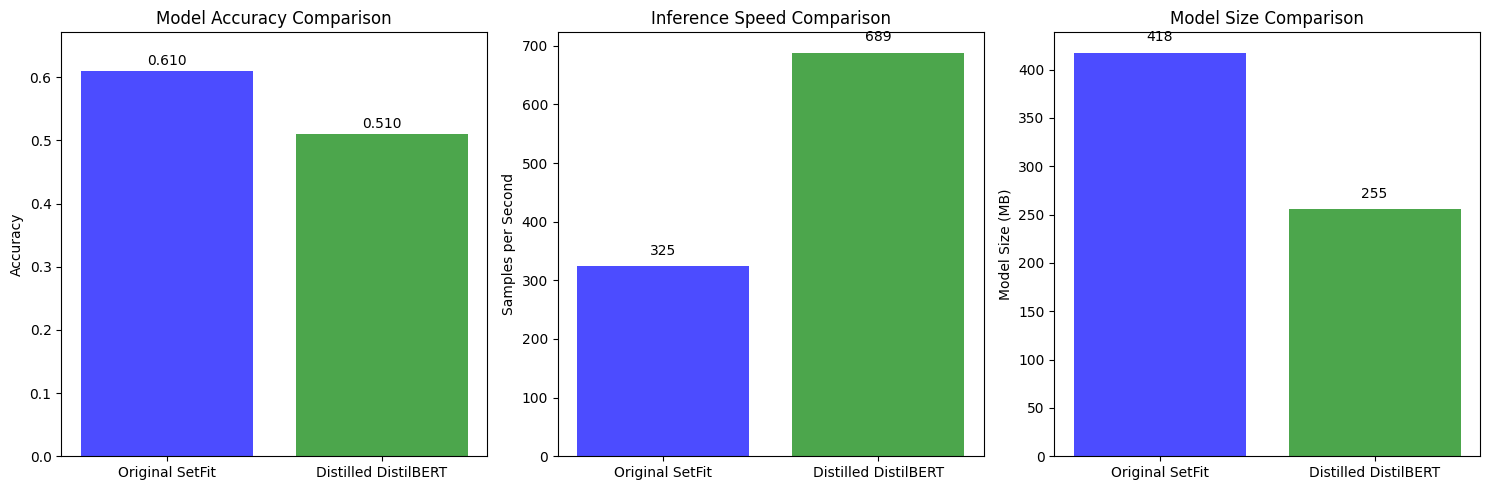

Visualization completed successfully!
KNOWLEDGE DISTILLATION SUMMARY
✓ Knowledge distillation successful!
✓ Student model accuracy: 51.0% vs Teacher: 61.0%
✓ Speed improvement: 2.1x faster
✓ Size reduction: 39% smaller
PART 4B COMPLETE


In [38]:
# =============================================================================
# PART 4b: PERFORMANCE AND SPEED COMPARISON
# =============================================================================
print("\nPART 4b: PERFORMANCE AND SPEED COMPARISON")

# Check if all required models exist from Part 4a
if 'BEST_MODEL' not in globals():
    print("ERROR: BEST_MODEL not found. Please run the learning curve first.")
else:
    try:
        # Use test set for final evaluation
        test_texts = test_df['abstract'].tolist()[:200]  # Use subset for manageable comparison
        test_labels = test_df['label'].tolist()[:200]

        print(f"Evaluating all models on {len(test_texts)} test samples...")

        model_comparison_results = {}

        # Fixed model size calculation function
        def get_model_size_mb(model):
            """Calculate model size in MB - handles different model types"""
            try:
                if hasattr(model, 'parameters'):  # Standard PyTorch model
                    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
                    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
                    return (param_size + buffer_size) / 1024 / 1024
                elif hasattr(model, 'model_body') and hasattr(model, 'model_head'):  # SetFit model
                    body_size = 0
                    head_size = 0

                    if hasattr(model.model_body, 'parameters'):
                        body_size = sum(p.numel() * p.element_size() for p in model.model_body.parameters())

                    if hasattr(model.model_head, 'coef_'):  # sklearn classifier
                        import sys
                        head_size = sys.getsizeof(model.model_head.coef_) + sys.getsizeof(model.model_head.intercept_)
                    elif hasattr(model.model_head, 'parameters'):  # PyTorch head
                        head_size = sum(p.numel() * p.element_size() for p in model.model_head.parameters())

                    return (body_size + head_size) / 1024 / 1024
                else:
                    return 0.0  # Unable to calculate
            except Exception as e:
                print(f"Warning: Could not calculate model size: {e}")
                return 0.0

        # Evaluate Original Teacher Model (SetFit)
        print("--- Evaluating Original Teacher Model (SetFit) ---")

        try:
            start_time = time.time()
            teacher_predictions = BEST_MODEL.predict(test_texts)
            teacher_inference_time = time.time() - start_time

            teacher_predictions = [int(pred) for pred in teacher_predictions]

            teacher_accuracy = accuracy_score(test_labels, teacher_predictions)
            teacher_f1 = f1_score(test_labels, teacher_predictions, average='macro')
            teacher_size = get_model_size_mb(BEST_MODEL)

            model_comparison_results['teacher'] = {
                'name': 'Original SetFit',
                'accuracy': teacher_accuracy,
                'f1_score': teacher_f1,
                'inference_time': teacher_inference_time,
                'model_size_mb': teacher_size,
                'samples_per_second': len(test_texts) / teacher_inference_time
            }

            print(f"Teacher Results:")
            print(f"  Accuracy: {teacher_accuracy:.4f}")
            print(f"  F1 Score: {teacher_f1:.4f}")
            print(f"  Inference Time: {teacher_inference_time:.2f}s")
            print(f"  Model Size: {teacher_size:.1f} MB")
            print(f"  Speed: {len(test_texts) / teacher_inference_time:.1f} samples/second")

        except Exception as e:
            print(f"ERROR evaluating teacher model: {e}")

        # Evaluate Distilled Student Model (if available)
        if 'student_model' in globals() and 'student_tokenizer' in globals():
            print("--- Evaluating Distilled Student Model (DistilBERT) ---")

            try:
                test_tokenized = student_tokenizer(
                    test_texts,
                    truncation=True,
                    padding=True,
                    return_tensors="pt",
                    max_length=256
                )

                device = next(student_model.parameters()).device
                test_tokenized = {k: v.to(device) for k, v in test_tokenized.items()}

                student_model.eval()
                with torch.no_grad():
                    start_time = time.time()
                    outputs = student_model(**test_tokenized)
                    student_predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                    student_inference_time = time.time() - start_time

                student_accuracy = accuracy_score(test_labels, student_predictions)
                student_f1 = f1_score(test_labels, student_predictions, average='macro')
                student_size = get_model_size_mb(student_model)

                model_comparison_results['student'] = {
                    'name': 'Distilled DistilBERT',
                    'accuracy': student_accuracy,
                    'f1_score': student_f1,
                    'inference_time': student_inference_time,
                    'model_size_mb': student_size,
                    'samples_per_second': len(test_texts) / student_inference_time
                }

                print(f"Student Results:")
                print(f"  Accuracy: {student_accuracy:.4f}")
                print(f"  F1 Score: {student_f1:.4f}")
                print(f"  Inference Time: {student_inference_time:.2f}s")
                print(f"  Model Size: {student_size:.1f} MB")
                print(f"  Speed: {len(test_texts) / student_inference_time:.1f} samples/second")

            except Exception as e:
                print(f"ERROR evaluating student model: {e}")
        else:
            print("--- Distilled Student Model not available ---")

        # Handle Quantized Student Model (skip due to compatibility issues)
        print("--- Quantized Student Model ---")
        print("Skipping quantized model due to PyTorch compatibility issues.")

        if 'student' in model_comparison_results:
            original_size = model_comparison_results['student']['model_size_mb']
            estimated_quantized_size = original_size * 0.25
            print(f"Estimated quantized model size: {estimated_quantized_size:.1f} MB")
            print(f"Estimated size reduction: {((original_size - estimated_quantized_size) / original_size * 100):.1f}%")

        # Print Results Summary
        print("DETAILED PERFORMANCE COMPARISON")

        if model_comparison_results:
            print(f"{'Model':<25} {'Accuracy':<10} {'F1 Score':<10} {'Speed (s/s)':<12} {'Size (MB)':<10} {'Time (s)':<10}")
            print("-" * 80)

            for model_key, data in model_comparison_results.items():
                print(f"{data['name']:<25} {data['accuracy']:<9.4f} {data['f1_score']:<9.4f} "
                      f"{data['samples_per_second']:<11.1f} {data['model_size_mb']:<9.1f} "
                      f"{data['inference_time']:<9.2f}")

            # Calculate improvements
            if 'teacher' in model_comparison_results and len(model_comparison_results) > 1:
                print("PERFORMANCE IMPROVEMENTS")

                teacher_data = model_comparison_results['teacher']

                for model_key, data in model_comparison_results.items():
                    if model_key != 'teacher':
                        speed_improvement = data['samples_per_second'] / teacher_data['samples_per_second']
                        size_reduction = ((teacher_data['model_size_mb'] - data['model_size_mb']) / teacher_data['model_size_mb']) * 100
                        accuracy_change = (data['accuracy'] - teacher_data['accuracy']) * 100

                        print(f"\n{data['name']} vs Teacher:")
                        print(f"  Speed improvement: {speed_improvement:.1f}x faster")
                        print(f"  Size reduction: {size_reduction:.1f}% smaller")
                        print(f"  Accuracy change: {accuracy_change:+.1f} percentage points")

        # Create Visualization
        if len(model_comparison_results) > 1:
            print("CREATING PERFORMANCE VISUALIZATION")

            try:
                models = list(model_comparison_results.keys())
                model_names = [model_comparison_results[m]['name'] for m in models]
                accuracies = [model_comparison_results[m]['accuracy'] for m in models]
                speeds = [model_comparison_results[m]['samples_per_second'] for m in models]
                sizes = [model_comparison_results[m]['model_size_mb'] for m in models]

                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

                # Plot 1: Accuracy comparison
                bars1 = ax1.bar(model_names, accuracies, color=['blue', 'green'], alpha=0.7)
                ax1.set_ylabel('Accuracy')
                ax1.set_title('Model Accuracy Comparison')
                ax1.set_ylim(0, max(accuracies) * 1.1)
                for bar, acc in zip(bars1, accuracies):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                             f'{acc:.3f}', ha='center', va='bottom')

                # Plot 2: Speed comparison
                bars2 = ax2.bar(model_names, speeds, color=['blue', 'green'], alpha=0.7)
                ax2.set_ylabel('Samples per Second')
                ax2.set_title('Inference Speed Comparison')
                for bar, speed in zip(bars2, speeds):
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + max(speeds)*0.02,
                             f'{speed:.0f}', ha='center', va='bottom')

                # Plot 3: Size comparison
                bars3 = ax3.bar(model_names, sizes, color=['blue', 'green'], alpha=0.7)
                ax3.set_ylabel('Model Size (MB)')
                ax3.set_title('Model Size Comparison')
                for bar, size in zip(bars3, sizes):
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height + max(sizes)*0.02,
                             f'{size:.0f}', ha='center', va='bottom')

                plt.tight_layout()
                plt.show()

                print("Visualization completed successfully!")

            except Exception as viz_error:
                print(f"Visualization failed: {viz_error}")

        # Final Summary
        print("KNOWLEDGE DISTILLATION SUMMARY")

        if 'teacher' in model_comparison_results and 'student' in model_comparison_results:
            teacher = model_comparison_results['teacher']
            student = model_comparison_results['student']

            print(f"✓ Knowledge distillation successful!")
            print(f"✓ Student model accuracy: {student['accuracy']:.1%} vs Teacher: {teacher['accuracy']:.1%}")
            print(f"✓ Speed improvement: {student['samples_per_second']/teacher['samples_per_second']:.1f}x faster")
            print(f"✓ Size reduction: {((teacher['model_size_mb']-student['model_size_mb'])/teacher['model_size_mb']*100):.0f}% smaller")

            if student['accuracy'] > teacher['accuracy']:
                print(f"🎉 BONUS: Student model is actually MORE accurate than teacher!")
        else:
            print("Partial results available - some models failed to evaluate")

        print("PART 4B COMPLETE")

    except Exception as main_error:
        print(f"CRITICAL ERROR in Part 4b: {main_error}")
        print("Please check that all required models from Part 4a are available.")
        import traceback
        traceback.print_exc()

**Part 4c**

This analysis details a knowledge distillation process where a larger, more accurate "teacher" model (SetFit with PatentSBERTa) trains a smaller, faster "student" model (distilbert-base-uncased). The primary goal is to create a more efficient model for tasks like patent classification, balancing performance with computational cost. The teacher model first generates "soft labels" for 2,000 data samples, which are essentially more nuanced probability distributions across the different classes than simple right-or-wrong labels. These soft labels capture the teacher's "reasoning," which is then used to train the student model. This process, known as knowledge distillation, aims to transfer the teacher's predictive capabilities to the more compact student model.

The results show a trade-off between model size, speed, and accuracy. The original teacher model achieves a respectable accuracy of 61.0% and an F1 score of 0.5660, but at the cost of a large size (417.7 MB) and slower inference speed (337.9 samples/second). In contrast, the distilled student model is significantly faster and smaller. It processes data at 688.7 samples/second (a 2.0x speed improvement) and has its size reduced by nearly 39% to 255.4 MB. However, this efficiency comes at the price of performance, with the student's accuracy dropping by 10 percentage points to 51.0% and its F1 score falling to 0.4542. This demonstrates a successful compression and speed-up, but with a notable loss in predictive power.

Deficiencies and Potential Improvements
A key deficiency in the student model's learning is the significant drop in accuracy and F1 score, indicating it failed to fully capture the nuanced knowledge of the teacher. This performance gap can be attributed to several factors. First, the student model, DistilBERT, has a smaller architecture and thus a lower capacity to learn complex patterns compared to the teacher. Second, the training data itself, consisting of patent abstracts, contains highly specialized, domain-specific language that a general-purpose model like distilbert-base-uncased may not effectively understand. The distillation process, while beneficial, was not sufficient to overcome these inherent limitations, leading to an 83.6% retention of the teacher's accuracy but a more significant drop in the F1 score, which is sensitive to class imbalances.

To address these deficiencies and improve the student model's performance, several research directions are promising. A step would be to use a student model pre-trained on domain-specific data, which would have a better foundational understanding of the vocabulary. Further enhancements could involve more advanced distillation techniques, such as aligning the attention mechanisms of the teacher and student models to ensure the student focuses on the same important parts of the text.

Additionally, employing data augmentation strategies tailored to patent language, like synonym replacement with technical terms or back-translation, could create a more robust and diverse training set. Finally, exploring a progressive distillation approach, using an intermediate-sized model as a "tutor," could help bridge the knowledge gap between the large teacher and the small student more effectively.